# references
https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52


In [1]:
from __future__ import print_function

import heapq
import hdbscan
import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
from pathlib import Path
import sys
import collections
from operator import itemgetter
import time
from tqdm.auto import tqdm
import re

from datetime import datetime
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib
## This is for backend, gui support, but it doesnt do anything ##
matplotlib.use('TkAgg')


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances

from sklearn.externals import joblib

from gensim import corpora, models, similarities
from nltk.tag import pos_tag
import string
from nltk.stem.snowball import SnowballStemmer
import re



%matplotlib inline

Rename RiskFactors > Data > Run  <for f in *\ *; do mv "$f" "${f// /_}"; done> in bash, in the folder "Data" 
This changes all " " characters to "_", needed for Path
See https://stackoverflow.com/a/18213120

In [2]:
def make_pipeline(NUMBER_OF_DOCS, istesting):
    doclist = []
    names = []
    pathlist = Path("Data_Small").glob('**/*.txt')
    pathlist = Path("Data").glob('**/*.txt')
    for path in tqdm(pathlist):
        # because path is object not string
        path_in_str = str(path)
        name = path_in_str.split("\\")[1].split(".")[0]
        names.append(name.replace("_", " "))
        # TODO SPLIT PATH TO COMPANY NAME, make Index
        file = open(path, "r")
        # print "Output of Readlines after appending"
        text = file.readlines()
    #     print(text[:10])
        doclist.append(text[0])
    if istesting == True:
        print('Test set generated')
        doclist = doclist[NUMBER_OF_DOCS:NUMBER_OF_DOCS * 2]
        names = names[NUMBER_OF_DOCS: NUMBER_OF_DOCS * 2]
    if len(doclist) > NUMBER_OF_DOCS:
        doclist = doclist[:NUMBER_OF_DOCS]
        names = names[:NUMBER_OF_DOCS]
    return doclist, names

In [3]:
doclist, names = make_pipeline(25, istesting=False)
print('%s docs loaded' % len(names))
print()
print(names[:5], '......',  names[-5:])

doclist[0][:500]


25 docs loaded

['180 Degree Capital Corp ', '1 800 FLOWERS COM Inc ', '2U Inc ', '3D Systems Corporation', '3M Company'] ...... ['Acadia Realty Trust', 'Accelerate Diagnostics Inc ', 'Acceleron Pharma Inc ', 'Accenture plc', 'Access National Corporation']


'[1] "Item 1A.    Risk Factors.. Investing in our common stock involves significant risks relating to our business and investment objectives. You should carefully consider the risks and uncertainties described below before you purchase any shares of our common stock. These risks and uncertainties are not the only ones we face. Unknown additional risks and uncertainties, or ones that we currently consider immaterial, may also impact our business. If any of these risks or uncertainties materialize,'

In [4]:
def transform_tokens(doclist):
    token_list = []
    for doc in tqdm(doclist, desc="Tokenizing", leave=True):
        dirty_tokens = nltk.sent_tokenize(doc)
        token_list += [dirty_tokens]
    return token_list

In [10]:
def transform_filtered(token_list, doclist, names):
    punc = ['.', ',', '"', "'", '?', '!', ':',
            ';', '(', ')', '[', ']', '{', '}', "%"]
    more_stops = ['\\t\\t\\t',
                  '\\t\\t\\', '\\t\\t\\t',
                  '<U+25CF>', '[1]', 'feff' , '1a', 'item']
    maybe_bad_stops = ['may', 'could',  'contents',
                       'table', 'time', '25cf', 'factors', 'risk', 
                   ]
    global Stopwords_list
    Stopwords_list = stopwords.words(
        'english') + more_stops + punc + maybe_bad_stops
    filtered_tokens = []
    #WE CAN RUN 1 or many docs at once# 
    names_list = []
    if len(names) > 1:
        if len(token_list) != len(doclist):
            token_list = [token_list]
        index = 0
        
        for tokens in tqdm(token_list, desc="Filtering Documents"):
            filtered_docs = []
            name = names[index]
            for token in tqdm(tokens, desc="Filtering Words", leave=False):
                if re.search(r'\d{1,}', token):  # getting rid of digits
                    pass
                else:
                    #                 NNP proper noun, singular ‘Harrison’
                    #                 NNPS proper noun, plural ‘Americans’
                    if token not in Stopwords_list:
                        if pos_tag(token) != 'NNP' and pos_tag(token) != 'NNPS':
                            filtered_docs.append(token.lower())
                        else:
                            filtered_docs.append('proper_noun')
                        names_list.append(name)
            index += 1
            filtered_tokens.append(filtered_docs)
        else:
             for token in tqdm(tokens, desc="Filtering Words", leave=False):
                if re.search(r'\d{1,}', token):  # getting rid of digits
                    pass
                else:
                    #                 NNP proper noun, singular ‘Harrison’
                    #                 NNPS proper noun, plural ‘Americans’
                    if token not in Stopwords_list:
                        if pos_tag(token) != 'NNP' and pos_tag(token) != 'NNPS':
                            filtered_docs.append(token.lower())
                        else:
                            filtered_docs.append('proper_noun')
    return filtered_tokens, names_list

In [19]:
def transform_stemming(filtered_tokens):
    stemmed = []
    for doc in filtered_tokens:
        for token in doc:
            stemmed.append(PorterStemmer().stem(token))
            # stemmed.append(LancasterStemmer().stem(token))
            # stemmed.append(SnowballStemmer('english').stem(token))

    return stemmed

In [20]:
def transform_vectorize(stemmed, smallest_ngram, largest_ngram):

    vectorizer = TfidfVectorizer(stop_words=Stopwords_list,
                                 ngram_range=(smallest_ngram, largest_ngram), max_df=0.55, min_df=0.01)
#     vectorizer = CountVectorizer(stop_words=Stopwords_list,
#                                  ngram_range=(smallest_ngram, largest_ngram), max_df=0.75, min_df=0.01)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    return sparseMatrix, vectorizer

In [21]:
tokens = transform_tokens(doclist)
filtered_tokens, names_list = transform_filtered(tokens, doclist, names)
stemmed = transform_stemming(filtered_tokens)

In [22]:
largest_ngram = 15
smallest_ngram = 1
largest_ngram = len(max(tokens, key=len))
print(smallest_ngram, largest_ngram)
max(tokens[0], key=len)


1 711


'Approximately 46 percent of the net asset value attributable to our equity-focused portfolio company investments, or 35 percent of our net asset value, as of December 31, 2016, is concentrated in D-Wave Systems, Inc., AgBiome, LLC, and HZO, Inc.. At December 31, 2016, we valued our investment in D-Wave Systems, Inc., which had a historical cost to us of $5,689,311, at $9,714,459, our investment in AgBiome, LLC, which had a historical cost to us of $3,021,746, at $9,214,997, and our investment in HZO, Inc., which had a historical cost to us of $9,132,398, at $6,613,046.. Any downturn in the business outlook and/or substantial changes in the funding requirements of D-Wave Systems, Inc., AgBiome, LLC, and HZO, Inc., could have a significant effect on the value of our current investments in those companies, and the overall value of our portfolio, and could have a significant adverse effect on the value of our common stock..'

In [23]:

%time sparseMatrix, vectorizer = transform_vectorize(stemmed, smallest_ngram, largest_ngram)

Wall time: 5.1 s


In [24]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.55, max_features=None, min_df=0.01,
        ngram_range=(1, 711), norm='l2', preprocessor=None,
        smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...)', '[', ']', '{', '}', '%', 'may', 'could', 'contents', 'table', 'time', '25cf', 'factors', 'risk'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [25]:
vectorizer.vocabulary_

{'common': 75,
 'stock': 380,
 'significant': 373,
 'risks': 361,
 'relating': 338,
 'business': 49,
 'investment': 195,
 'common stock': 76,
 'purchase': 326,
 'shares': 372,
 'face': 146,
 'additional': 13,
 'currently': 104,
 'also': 26,
 'impact': 178,
 'financial': 153,
 'condition': 85,
 'results': 353,
 'operations': 268,
 'materially': 240,
 'adversely': 19,
 'affected': 24,
 'business financial': 50,
 'financial condition': 154,
 'condition results': 86,
 'results operations': 354,
 'materially adversely': 241,
 'adversely affected': 21,
 'business financial condition': 51,
 'financial condition results': 155,
 'condition results operations': 87,
 'business financial condition results': 52,
 'financial condition results operations': 156,
 'business financial condition results operations': 53,
 'event': 136,
 'price': 302,
 'decline': 110,
 'lose': 219,
 'part': 276,
 'related': 337,
 'change': 65,
 'end': 131,
 'price common': 303,
 'price common stock': 304,
 'required': 344,

In [26]:
import matplotlib.pyplot as plt
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [27]:
sparseMatrix
# With this, each column in the matrix represents a word in the vocabulary
# each row represents the document in our dataset
# where the values in this case are the word counts or Doc Freq if we are using tfidf vectorizer

<7466x426 sparse matrix of type '<class 'numpy.float64'>'
	with 73122 stored elements in Compressed Sparse Row format>

C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


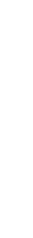

In [28]:
plot_coo_matrix(sparseMatrix).figure.show()
# This is causing mem issues 2/12/19

In [29]:
# from sklearn.model_selection import GridSearchCV    
# model = KMeans(init='k-means++', random_state=42, n_init=15
#                    )
# param_grid = {'max_iter': [10, 50, 100, 150, 200, 250, 300, 350, 400, 500, 1000],
#              'n_clusters': [25,30, 33, 35],
#              }
# grid = GridSearchCV(model, param_grid, verbose=3, n_jobs=8)
# grid.fit(sparseMatrix)

# lids = model.cluster_centers_
  
# score = model.score(sparseMatrix)
# silhouette_score = metrics.silhouette_score(sparseMatrix, labels, metric='euclidean')


In [30]:
# List the best parameters for this dataset
# print(grid.best_params_)
# List the best score
# print(grid.best_score_)

In [31]:
def estimator_cluster(sparseMatrix, vectorizer):
    truek = 35 ## FROM GRID SEARCH
    model = KMeans(n_clusters=truek, init='k-means++',
                   max_iter=50, n_init=1, random_state=42,
                   )
    model.fit(sparseMatrix)
    
    model_time = datetime.now().strftime("%b%d-%I%M%p")
    joblib.dump(model,  f'outputs/s2s{model_time}.pkl')
    joblib.dump(vectorizer,  f'outputs/vec{model_time}.pkl')
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()

    return terms, order_centroids, model, truek, model_time

In [32]:
# THIS TAKES ~~ 1m per 100 documents
%time terms, order_centroids, model, truek, model_time = estimator_cluster(sparseMatrix, vectorizer)

Wall time: 8.48 s


In [33]:
def estimator_ppscore(model):
    labels = model.labels_
    centroids = model.cluster_centers_

    print(f"Model Generated at {model_time}")
    
    print ("Cluster id labels for inputted data")
    print (labels)
    print ("Centroids data")
    #print (centroids)

    kmeans_score  = model.score(sparseMatrix)
    print ("Score (Opposite of the value of X on the K-means objective, \n",
           "which is Sum of distances of samples to their closest cluster center):")
    print (kmeans_score)

    silhouette_score = metrics.silhouette_score(sparseMatrix, labels, metric='euclidean')

    print ("Silhouette_score: ")
    print (silhouette_score)
    return kmeans_score, silhouette_score


estimator_ppscore(model)

Model Generated at Feb14-0130PM
Cluster id labels for inputted data
[17  9  9 ... 20  2 17]
Centroids data
Score (Opposite of the value of X on the K-means objective, 
 which is Sum of distances of samples to their closest cluster center):
-6114.358430309474
Silhouette_score: 
0.024280048595816534


(-6114.358430309474, 0.024280048595816534)

In [85]:
# using joblib to pickle model
def estimator_load_model(model_time):
    model = joblib.load(f'outputs/s2s{model_time}.pkl')
    vectorizer = joblib.load(f'outputs/vec{model_time}.pkl')
    return model, vectorizer
# TODO IMPORTANT RETURN VECTORIZER
model, vectorizer = estimator_load_model('Feb14-0130PM')


In [86]:
nclosest_words_to_show = 10
for i in range(truek):
    print('Cluster %d:' % i),
    for ind in order_centroids[i, :nclosest_words_to_show]:
        print(' %s' % terms[ind])

Cluster 0:
 pay
 ability
 cash
 services
 required
 result
 party
 care
 capital
 us
Cluster 1:
 patent
 applications
 patents
 issued
 enforcement
 litigation
 claims
 protection
 united states
 united
Cluster 2:
 period
 revenue
 results
 end
 operating
 products
 sales
 number
 fluctuations
 result
Cluster 3:
 stock
 price
 common
 common stock
 price common
 price common stock
 market
 market price
 decline
 shares
Cluster 4:
 personnel
 key
 management
 retain
 employees
 attract
 operations
 ability
 business
 sales
Cluster 5:
 operating
 operating results
 results
 business
 financial
 future
 expenses
 revenue
 financial condition
 condition
Cluster 6:
 drug
 candidates
 development
 nuplazid
 regulatory
 approved
 fda
 manufacture
 products
 product
Cluster 7:
 local
 international
 face
 comply
 limited
 united states
 united
 states
 requirements
 risks
Cluster 8:
 capital
 debt
 additional
 financing
 equity
 terms
 available
 cash
 future
 us
Cluster 9:
 stock
 common stoc

In [87]:
def estimator_predict_string(string):
    empty_list = []
    print('Input String: %s' % string)
    print('\n')
    print('Prediction:')
                
    X = vectorizer.transform([string])
    predicted = model.predict(X)
    print('kmeans prediction: %s' % predicted)
    print("closest cluster centers :")
    for ind in order_centroids[predicted[0], :2]:
        print(' %s' % terms[ind])
    return X


In [88]:
# estimator_predict_string ('The hackers stole all our bitcoin!')

In [89]:
terms

['abbvie',
 'ability',
 'able',
 'access',
 'accounting',
 'achieve',
 'acquisition',
 'acquisitions',
 'act',
 'action',
 'actions',
 'activities',
 'addition',
 'additional',
 'additionally',
 'adequate',
 'adverse',
 'adverse effect',
 'adverse effect business',
 'adversely',
 'adversely affect',
 'adversely affected',
 'affect',
 'affect business',
 'affected',
 'agreements',
 'also',
 'although',
 'among',
 'amount',
 'applicable',
 'applications',
 'approval',
 'approvals',
 'approved',
 'arrangements',
 'assets',
 'associated',
 'assurance',
 'attract',
 'authorities',
 'availability',
 'available',
 'based',
 'basis',
 'become',
 'believe',
 'benefits',
 'board',
 'business',
 'business financial',
 'business financial condition',
 'business financial condition results',
 'business financial condition results operations',
 'business results',
 'business results operations',
 'businesses',
 'candidates',
 'cannot',
 'capital',
 'care',
 'cash',
 'cash flows',
 'cause',
 'certain

In [90]:
# SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta
strings = [
    'Topic 0: investment, property, distribution, interest, agreement',
    'Topic 1: regulation, change, law, financial, operation, tax, accounting ',
    'Topic 2: gas, price, oil, natural, operation, production Input prices risks ',
    'Topic 3: stock, price, share, market, future, dividend, security, stakeholder ',
    'Topic 4: cost, regulation, environmental, law, operation, liability',
    'Topic 5: control, financial, internal, loss, reporting, history ',
    'Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit'
    'Topic 7: competitive, industry, competition, highly',
    'Topic 8: cost, operation, labor, operating, employee, increase, acquisition ',
    'Topic 9: product, candidate, development, approval, clinical, regulatory',
    'Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible ',
    'Topic 11: interest, director, officer, trust, combination, share, conflict ',
    'Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products',
    'Topic 13: loan, real, estate, investment, property, market, loss, portfolio ',
    'Topic 14: personnel, key, retain, attract, management, employee ',
    'Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile  ',
    'Topic 16: acquisition, growth, future, operation, additional, capital, strategy ',
    'Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks ',
    'Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations'
    'Topic 19: cost, contract, operation, plan, increase, pension, delay',
    'Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers',
    'Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm',
    'Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results',
    'Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw',
    'Topic 24: regulation, government, change, revenue, contract, law, service',
    'Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade ',
    'Topic 26: debt, indebtedness, cash, obligation, financial, credit, ',
    'Topic 27: operation, international, foreign, currency, rate, fluctuation',
    'Topic 28: loss, insurance, financial, loan, reserve, operation, cover',
    'Topic 29: operation, natural, facility, disaster, event, terrorist, weather ']
topics = [topic.split(":")[1] for topic in strings]

In [91]:
targets = {
    "Shareholder’s interest risk": topics[0],
    "Regulation changes(accounting)": topics[1],
    "Stakeholder’s profit": topics[2],
    "Regulation changes(environment)": topics[3],
    "Legal Risks": topics[4],
    "Financial condition risks ": topics[5],
    " Potential/Ongoing Lawsuits": topics[6],
    "market Competition risks": topics[7],
    "**Labor cost ": topics[8],
    " New product introduction risks ": topics[9],
    "**Accounting,  +Restructuring risks ": topics[10],
    "**Management": topics[11],
    " Potential defects in products": topics[12],
    "**Investment": topics[13],
    "Human resource risks": topics[13],
    "Volatile stock price risks": topics[14],
    "Merger & Acquisition risks": topics[15],
    " +Industry is cyclical": topics[16],
    " **Postpone ":  topics[17],
    " +Infrastructure risks": topics[18],
    "+Suppliers risks +Downstream risks": topics[19],
    "license Intellectual property risks": topics[20],
    "+Licensing related risks' ": topics[21],
    "+ Competition risks ": topics[22],
    "*Potential/Ongoing Lawsuits*": topics[23],
    "Regulation changes": topics[24],
    "Credit risks": topics[25],
    "covenant Funding risks ": topics[26],
    "International risks": topics[27],
    #     "Insurance" : topics[28],
    #     "Catastrophes" : topics[29]
}

In [92]:
for topic in topics:
    print(topic)
    estimator_predict_string(topic)

 investment, property, distribution, interest, agreement
Input String:  investment, property, distribution, interest, agreement


Prediction:
kmeans prediction: [15]
closest cluster centers :
 rates
 interest
 regulation, change, law, financial, operation, tax, accounting 
Input String:  regulation, change, law, financial, operation, tax, accounting 


Prediction:
kmeans prediction: [31]
closest cluster centers :
 tax
 income
 gas, price, oil, natural, operation, production Input prices risks 
Input String:  gas, price, oil, natural, operation, production Input prices risks 


Prediction:
kmeans prediction: [27]
closest cluster centers :
 risks
 business
 stock, price, share, market, future, dividend, security, stakeholder 
Input String:  stock, price, share, market, future, dividend, security, stakeholder 


Prediction:
kmeans prediction: [3]
closest cluster centers :
 stock
 price
 cost, regulation, environmental, law, operation, liability
Input String:  cost, regulation, environment

In [93]:
doclist, names = make_pipeline(15, istesting=True)



Test set generated


In [94]:
def estimator_predict_document(document, name):
    dictionary_list = []
    for counter, sentence in enumerate(document.split(".")):
        if len(sentence) != 0:
            vector_matrix = vectorizer.transform([sentence])
            predicted_label = model.predict(vector_matrix)
            sentence_len = len(sentence.split(" "))
            sentence_info = {'company': name, 'sentence#': counter, 'text': sentence,
                             'wordcount': sentence_len, 'label': predicted_label[0]}
            dictionary_list.append(sentence_info)
    dataframe = pd.DataFrame(dictionary_list)
    dataframe["% of total"]  = dataframe['wordcount'] / sum(dataframe['wordcount'])
#         (name, sentence, predicted_label)
    return(dataframe)

In [95]:
frames = []
for document, name in zip(doclist, names):
    frame = estimator_predict_document(document, name)
    frames.append(frame)
    
muliple_company_frame = pd.concat(frames)
muliple_company_frame.head()

,company,label,sentence#,text,wordcount,% of total
0,Abraxas Petroleum Corporation,17,0,"[1] ""Item 1A",3,0.000210
1,Abraxas Petroleum Corporation,17,1,Risk Factors,3,0.000210
2,Abraxas Petroleum Corporation,27,2,Risks Related to Our Business,6,0.000420
3,Abraxas Petroleum Corporation,19,3,Depressed oil and/or gas prices would have a ...,15,0.001051
4,Abraxas Petroleum Corporation,17,5,15,2,0.000140


In [96]:
grouped_frame = muliple_company_frame.groupby(['company', 'label']).agg({'% of total': 'sum'}).reset_index()
grouped_frame.head()

,company,label,% of total
0,ACADIA Pharmaceuticals Inc,0,0.003924
1,ACADIA Pharmaceuticals Inc,1,0.059268
2,ACADIA Pharmaceuticals Inc,2,0.009376
3,ACADIA Pharmaceuticals Inc,3,0.019453
4,ACADIA Pharmaceuticals Inc,4,0.014993


In [97]:
def prep_for_heatmap(muliple_company_frame):
    company_clusters = muliple_company_frame.groupby(['label', 'company']).agg(
        {'% of total': 'sum'}).unstack(level = 'company').fillna(0).T

    company_clusters = company_clusters.reset_index(level=0,drop=True)
    return company_clusters

company_clusters = prep_for_heatmap(muliple_company_frame)
company_clusters.head()

label,0,1,2,3,4,5,6,8,9,10,...,25,26,27,28,29,30,31,32,33,34
company,,,,,,,,,,,,,,,,,,,,,
ACADIA Pharmaceuticals Inc,0.003924,0.059268,0.009376,0.019453,0.014993,0.008426,0.056377,0.007310,0.020610,0.014084,...,0.010862,0.004915,0.003717,0.016975,0.040228,0.027177,0.014745,0.002024,0.002313,0.120601
Abraxas Petroleum Corporation,0.002522,0.000000,0.010929,0.013241,0.007636,0.009948,0.000000,0.084770,0.025151,0.000000,...,0.004624,0.033487,0.032857,0.010789,0.000000,0.006235,0.022418,0.013801,0.008127,0.004344
Acacia Communications Inc,0.003023,0.003915,0.017591,0.017145,0.022001,0.028988,0.000000,0.011000,0.034091,0.028641,...,0.005946,0.041376,0.012537,0.022843,0.000000,0.164263,0.077102,0.005698,0.004014,0.035083
Acacia Research Corporation,0.000000,0.205939,0.017321,0.026769,0.003037,0.039703,0.000000,0.045214,0.027331,0.003374,...,0.022720,0.005511,0.023957,0.013722,0.000000,0.029356,0.040940,0.029131,0.000000,0.003599
Acadia Healthcare Company Inc,0.040984,0.000000,0.005510,0.017632,0.025714,0.015008,0.000000,0.052792,0.011650,0.000000,...,0.015271,0.063969,0.009498,0.001522,0.000000,0.002047,0.010915,0.025714,0.003621,0.000000


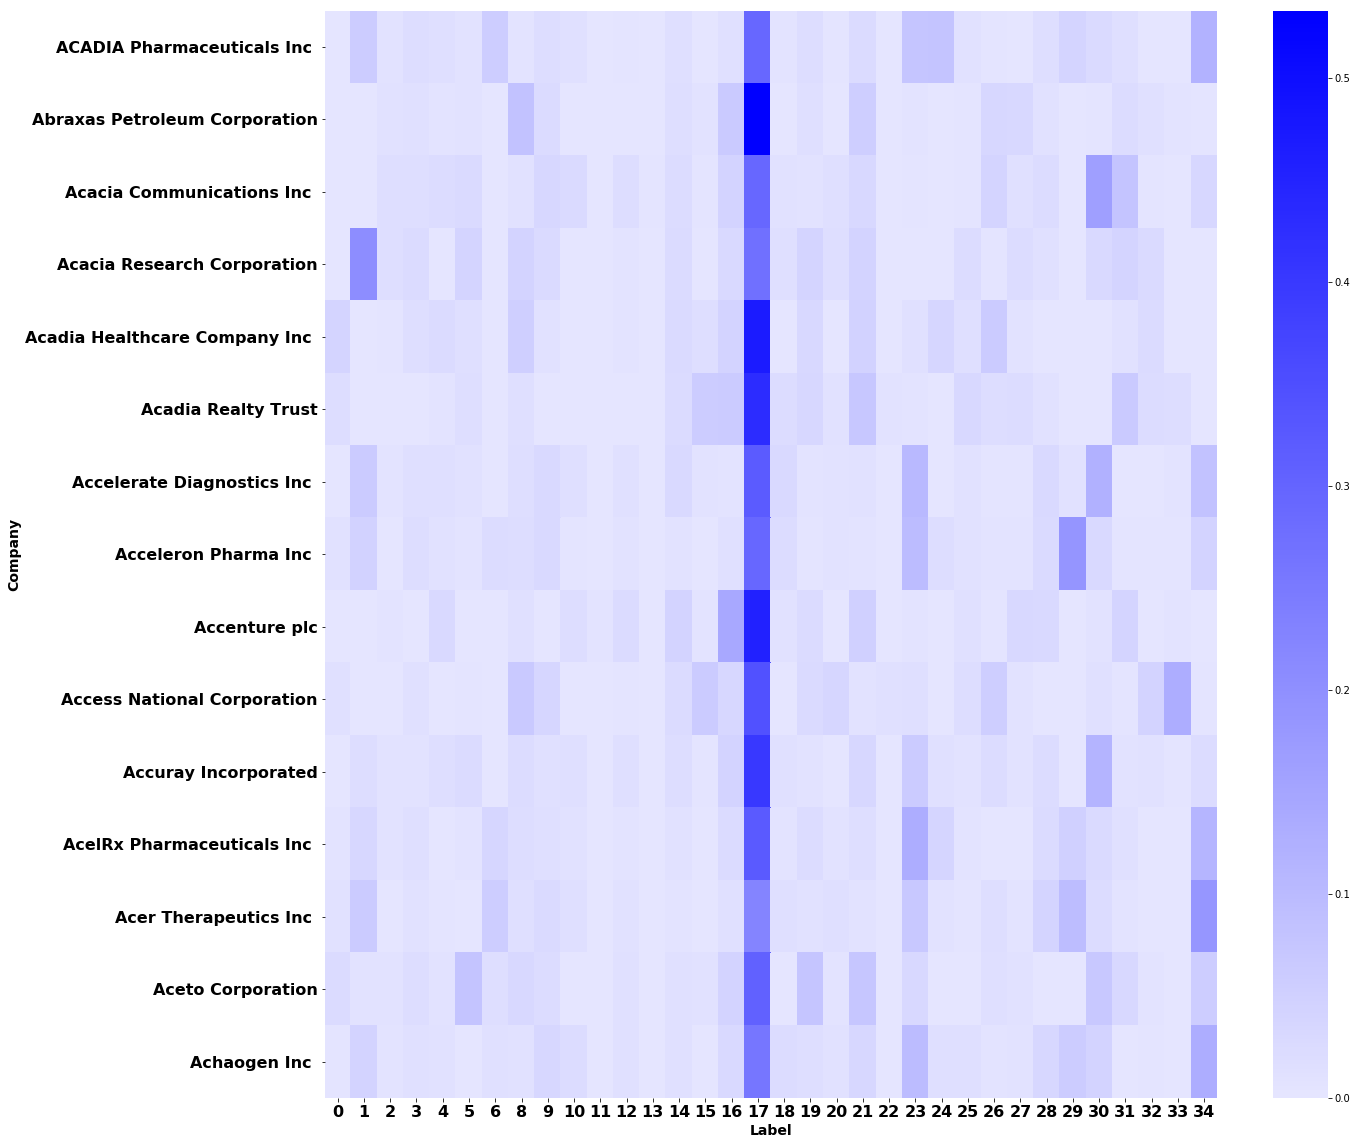

In [98]:
def plot_heatmap(company_clusters):
    fig2, ax2 = plt.subplots(figsize=(20, 20))
    cmap = sns.light_palette('blue', as_cmap=True)

    sns.heatmap(company_clusters, ax=ax2, cmap=cmap)

    ax2.set_xlabel('Label', fontdict={'weight': 'bold', 'size': 14})
    ax2.set_ylabel('Company', fontdict={'weight': 'bold', 'size': 14})
    for label in ax2.get_xticklabels():
        label.set_size(16)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")
    plt.savefig("outputs/Heatmap.jpg", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    
plot_heatmap(company_clusters)

In [99]:
company_clusters.T.head()

company,ACADIA Pharmaceuticals Inc,Abraxas Petroleum Corporation,Acacia Communications Inc,Acacia Research Corporation,Acadia Healthcare Company Inc,Acadia Realty Trust,Accelerate Diagnostics Inc,Acceleron Pharma Inc,Accenture plc,Access National Corporation,Accuray Incorporated,AcelRx Pharmaceuticals Inc,Acer Therapeutics Inc,Aceto Corporation,Achaogen Inc
label,,,,,,,,,,,,,,,
0,0.003924,0.002522,0.003023,0.000000,0.040984,0.020809,0.003150,0.012468,0.004079,0.014240,0.002669,0.006820,0.011135,0.025940,0.004467
1,0.059268,0.000000,0.003915,0.205939,0.000000,0.000000,0.060993,0.047575,0.000000,0.000000,0.020123,0.033519,0.063122,0.009196,0.043016
2,0.009376,0.010929,0.017591,0.017321,0.005510,0.002640,0.006481,0.002126,0.007837,0.003207,0.009624,0.008598,0.003903,0.008578,0.007175
3,0.019453,0.013241,0.017145,0.026769,0.017632,0.003649,0.016596,0.019995,0.000000,0.013214,0.010062,0.015159,0.012102,0.020176,0.013978
4,0.014993,0.007636,0.022001,0.003037,0.025714,0.006445,0.015930,0.012181,0.030950,0.000000,0.017324,0.003782,0.005478,0.008441,0.010627


In [100]:
import colorsys
#  https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
def get_N_HexCol(N):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out
colormap = get_N_HexCol(truek)

In [101]:
from IPython.display import display, Markdown
for label in range(truek):
    color = colormap[label]
    display(Markdown(f'<font color="{color}">Cluster {label}</font>'))

<font color="#7f3f3f">Cluster 0</font>

<font color="#7f4a3f">Cluster 1</font>

<font color="#7f553f">Cluster 2</font>

<font color="#7f603f">Cluster 3</font>

<font color="#7f6b3f">Cluster 4</font>

<font color="#7f763f">Cluster 5</font>

<font color="#7d7f3f">Cluster 6</font>

<font color="#727f3f">Cluster 7</font>

<font color="#677f3f">Cluster 8</font>

<font color="#5c7f3f">Cluster 9</font>

<font color="#517f3f">Cluster 10</font>

<font color="#477f3f">Cluster 11</font>

<font color="#3f7f43">Cluster 12</font>

<font color="#3f7f4e">Cluster 13</font>

<font color="#3f7f59">Cluster 14</font>

<font color="#3f7f64">Cluster 15</font>

<font color="#3f7f6f">Cluster 16</font>

<font color="#3f7f7a">Cluster 17</font>

<font color="#3f7a7f">Cluster 18</font>

<font color="#3f6f7f">Cluster 19</font>

<font color="#3f647f">Cluster 20</font>

<font color="#3f597f">Cluster 21</font>

<font color="#3f4e7f">Cluster 22</font>

<font color="#3f437f">Cluster 23</font>

<font color="#473f7f">Cluster 24</font>

<font color="#513f7f">Cluster 25</font>

<font color="#5c3f7f">Cluster 26</font>

<font color="#673f7f">Cluster 27</font>

<font color="#723f7f">Cluster 28</font>

<font color="#7d3f7f">Cluster 29</font>

<font color="#7f3f76">Cluster 30</font>

<font color="#7f3f6b">Cluster 31</font>

<font color="#7f3f60">Cluster 32</font>

<font color="#7f3f55">Cluster 33</font>

<font color="#7f3f4a">Cluster 34</font>

In [102]:

company = muliple_company_frame['company'].unique()[0]
companyFrame = muliple_company_frame[muliple_company_frame['company']==company]
for text, label  in zip(companyFrame['text'], companyFrame['label']):
    color = colormap[label]
    display(Markdown(f'<font color="{color}">' + text + f'  ({label})' + '</font>'))

<font color="#3f7f7a">[1] "Item 1A  (17)</font>

<font color="#3f7f7a"> Risk Factors  (17)</font>

<font color="#673f7f"> Risks Related to Our Business  (27)</font>

<font color="#3f6f7f"> Depressed oil and/or gas prices would have a material and adverse effect on us  (19)</font>

<font color="#3f7f7a"> 15  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> Our financial results and the value of our properties are highly dependent on the general supply and demand for oil, gas and NGL, which impact the prices we ultimately realize on our sales of these commodities  (17)</font>

<font color="#7f763f"> Since the second half of 2014, there has been a significant decline in oil, gas and NGL prices, which adversely affected our 2015 and 2016 operating results and contributed to a reduction in our anticipated future capital expenditures  (5)</font>

<font color="#3f7f7a"> In addition, this decline in commodity prices adversely impacted our estimated proved reserves and resulted in a proved property impairment of $128  (17)</font>

<font color="#3f7f7a">6 million to our oil and gas properties during 2015 and $67  (17)</font>

<font color="#3f7f7a">6 million in 2016  (17)</font>

<font color="#3f7f7a"> We could record impairments in future periods, the amount of which will be dependent upon many factors such as future prices of oil, gas and NGL, increases or decreases in our reserve base, changes in estimated costs and expenses, and oil and gas property acquisitions  (17)</font>

<font color="#3f7f7a"> While oil and gas prices began to improve in late 2016 and remained at somewhat improved levels in 2017, prices have remained relatively low and price volatility has continued  (17)</font>

<font color="#3f7f6f"> A sustained weakness or further deterioration in commodity prices could materially and adversely impact our business by resulting in, or exacerbating, the following effects:  (16)</font>

<font color="#3f7f7a"> • reducing the amount of oil, gas and NGL that we can produce economically;  (17)</font>

<font color="#3f7f7a"> • reducing the borrowing base of our credit facility;  (17)</font>

<font color="#677f3f"> • limiting our financial flexibility, liquidity and access to sources of capital, such as equity and debt;  (8)</font>

<font color="#3f7f6f"> • reducing our revenues,  cash flows from operations and profitability;  (16)</font>

<font color="#677f3f"> • causing us to decrease our capital expenditures or maintain reduced capital spending for an extended period, resulting in lower future production of oil, gas and NGL; and  (8)</font>

<font color="#3f7f7a"> • reducing the carrying value of our properties, resulting in additional noncash write-downs  (17)</font>

<font color="#3f7f7a"> Market prices and our realized prices have been volatile and are likely to continue to be volatile in the future due to numerous factors beyond our control  (17)</font>

<font color="#3f7f7a"> These factors include:  (17)</font>

<font color="#3f7f7a"> • the level of demand;  (17)</font>

<font color="#3f7f7a"> • domestic and global supplies of oil, NGL and gas;  (17)</font>

<font color="#3f7f7a"> • the price and quantity of imported and exported oil, NGL and gas;  (17)</font>

<font color="#3f7f7a"> • the actions of other oil exporting nations;  (17)</font>

<font color="#3f7f59"> • weather conditions and changes in weather patterns;  (14)</font>

<font color="#3f7f7a"> • the availability, proximity and capacity of appropriate transportation facilities, gathering, processing and compression facilities, storage facilities and refining facilities;  (17)</font>

<font color="#3f7f7a"> • worldwide economic and political conditions, including political instability or armed conflict in oil and gas producing regions, competition for markets and political initiatives disfavoring fossil fuels;  (17)</font>

<font color="#3f7f7a"> • the price and availability of, and demand for, competing energy sources, including alternative energy sources;  (17)</font>

<font color="#3f7f7a"> • the nature and extent of governmental regulation, including environmental regulation, regulation of derivatives transactions and hedging activities, tax laws and regulations and laws and regulations with respect to the import and export of oil, gas and related commodities;  (17)</font>

<font color="#3f7f7a"> • the level and effect of trading in commodity futures markets, including trading by commodity price speculators and others, and;  (17)</font>

<font color="#3f7f7a"> • the effect of worldwide energy conservation measures  (17)</font>

<font color="#3f7f6f"> Our cash flows from operations, results of operations and the borrowing base under our credit facility depend to a great extent on the prevailing prices for oil and gas  (16)</font>

<font color="#3f7f6f"> Prolonged or substantial declines in oil and/or gas prices would materially and adversely affect our liquidity, the amount of cash flows we have available for our capital expenditures and other operating expenses, our ability to access the credit and capital markets and our results of operations  (16)</font>

<font color="#3f7f7a"> Any significant reduction in the borrowing base under our credit facility as a result of a periodic borrowing base redetermination or otherwise will negatively impact our liquidity and, consequently, our ability to fund our operations, and we may not have sufficient funds to repay borrowings under our credit facility or any other obligation if required as a result of a borrowing base redetermination  (17)</font>

<font color="#3f7f7a"> 16  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> Availability under our credit facility is currently subject to a borrowing base of $135  (17)</font>

<font color="#3f7f7a">0 million  (17)</font>

<font color="#3f7f7a">  The borrowing base is subject to scheduled semiannual (April 1 and October 1) and other elective borrowing base redeterminations  (17)</font>

<font color="#3f7f7a">  The amount of the borrowing base is calculated by the lenders based upon their valuation of our proved reserves securing the facility utilizing these reserve reports and their own internal decisions  (17)</font>

<font color="#3f7f7a">  The lenders under our credit facility can unilaterally adjust the borrowing base and the borrowings permitted to be outstanding under our credit facility  (17)</font>

<font color="#3f7f7a">  A number of factors could reduce our borrowing base, including:  (17)</font>

<font color="#3f7f7a"> • lower commodity prices or production;  (17)</font>

<font color="#3f7f7a"> • a reduction in reserve estimates;  (17)</font>

<font color="#7f763f"> • inability to drill or unfavorable drilling results;  (5)</font>

<font color="#677f3f"> • increased operating and/or capital costs;  (8)</font>

<font color="#3f7f7a"> • the lenders' inability to agree to an adequate borrowing base; or  (17)</font>

<font color="#3f7f59"> • adverse changes in the lenders' practices (including required regulatory changes) regarding estimation of reserves  (14)</font>

<font color="#3f7f7a"> As of March 9, 2018, we had $103  (17)</font>

<font color="#3f7f7a">0 million of borrowings outstanding and availability of $32  (17)</font>

<font color="#3f7f7a">0 million under our credit facility  (17)</font>

<font color="#3f6f7f">  Any significant reduction in our borrowing base as a result of borrowing base redeterminations or otherwise will negatively impact our liquidity and our ability to fund our operations and, as a result, would have a material adverse effect on our financial position, results of operations and cash flows from operations  (19)</font>

<font color="#3f7f7a">  Further, if the outstanding borrowings under our credit facility were to exceed the borrowing base as a result of redetermination, we would be required to repay the excess amount or pledge additional assets  (17)</font>

<font color="#3f7f7a">  We may not have sufficient funds to make such repayment and we do not have any substantial unpledged assets  (17)</font>

<font color="#3f7f7a">  If we do not have sufficient funds and we are otherwise unable to negotiate renewals of our borrowings or arrange new financing, we may have to sell significant assets  (17)</font>

<font color="#3f6f7f">  Any such sale could have a material adverse effect on our business and financial results  (19)</font>

<font color="#3f7f7a"> Lower oil and/or gas prices may also reduce the amount of oil and/or gas that we can produce economically  (17)</font>

<font color="#3f7f7a"> Sustained substantial declines in oil and/or gas prices may render uneconomic a significant portion of our exploration, development and exploitation projects, which may result in our having to make significant downward adjustments to our estimated proved reserves  (17)</font>

<font color="#5c3f7f"> As a result, a prolonged or substantial decline in oil and/or gas prices such as we have experienced since mid-2014 has in the past caused, and would likely in the future cause, a material and adverse effect on our future business, financial condition, results of operations, liquidity and ability to finance capital expenditures  (26)</font>

<font color="#3f7f7a"> Additionally, if we experience significant sustained decreases in oil and gas prices such that the expected future cash flows from our oil and gas properties falls below the net book value of our properties, we may be required to write down the value of our oil and gas properties  (17)</font>

<font color="#7f603f"> Any such asset impairments could materially and adversely affect our results of operations and, in turn, the trading price of our common stock  (3)</font>

<font color="#677f3f"> We may not be able to fund the capital expenditures that will be required for us to increase reserves and production  (8)</font>

<font color="#677f3f"> We must make capital expenditures to develop our existing reserves and to discover new reserves  (8)</font>

<font color="#677f3f">  Historically, we have financed our capital expenditures primarily with cash flows from operations, borrowings under credit facilities, sales of properties, monetizing derivative contracts and sales of debt and equity securities and we expect to continue to utilize these sources in the future to the extent available  (8)</font>

<font color="#677f3f">  We cannot assure you that we will have sufficient capital resources in the future to finance all of our planned capital expenditures  (8)</font>

<font color="#3f7f6f"> Volatility in oil and gas prices, the timing of our drilling programs and drilling results will affect our cash flows from operations  (16)</font>

<font color="#677f3f">  Lower prices and/or lower production could also decrease revenues and cash flows from operations, thus reducing the amount of financial resources available to meet our capital requirements, including reducing the amount available to pursue our drilling opportunities  (8)</font>

<font color="#677f3f">  If our cash flows from operations does not increase as a result of capital expenditures, a greater percentage of our cash flows from operations will be required for debt service and operating expenses and our capital expenditures would, by necessity, be decreased  (8)</font>

<font color="#3f7f7a"> The borrowing base under our credit facility is determined from time to time by the lenders  (17)</font>

<font color="#677f3f">  Reductions in estimates of oil and gas reserves could result in a reduction in the borrowing base, which would reduce the amount of financial resources available under our credit facility to meet our capital requirements and/or trigger certain repayment obligations  (8)</font>

<font color="#3f7f59">   Such a reduction could be the result of lower commodity prices and/or production, an inability to drill or unfavorable drilling results, changes in oil and gas reserve engineering, the lenders' inability to agree to an adequate borrowing base or adverse changes in the lenders' practices regarding estimation of reserves  (14)</font>

<font color="#3f7f7a"> 17  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f6f"> If cash flows from operations or our borrowing base decrease, our ability to undertake exploration and development activities could be adversely affected  (16)</font>

<font color="#3f7f7a">  As a result, our ability to replace production may be limited  (17)</font>

<font color="#3f7f7a">  In addition, if the borrowing base under our credit facility is reduced, we would be required to reduce borrowings under our credit facility so that such borrowings do not exceed the borrowing base  (17)</font>

<font color="#677f3f">  This could further reduce the cash available to us for capital spending and, if we did not have sufficient capital to reduce our borrowing level, we may be in default under the credit facility  (8)</font>

<font color="#677f3f"> We have sold producing properties to provide us with liquidity and capital resources in the past and we may continue to do so in the future  (8)</font>

<font color="#3f7f7a">  After any such sale, we would expect to utilize the proceeds to reduce our indebtedness and/or to drill new wells on our remaining properties  (17)</font>

<font color="#677f3f">  If we cannot replace the production from the properties sold with production from our remaining properties, our cash flows from operations will likely decrease, which in turn, could decrease the amount of cash available for additional capital spending  (8)</font>

<font color="#3f7f6f"> We have indebtedness which may adversely affect our cash flows and business operations  (16)</font>

<font color="#3f7f7a"> At December 31, 2017, we had a total of $84  (17)</font>

<font color="#3f7f7a">0 million of indebtedness under our credit facility and total indebtedness of $87  (17)</font>

<font color="#3f7f7a">6 million (including the current portion)  (17)</font>

<font color="#3f7f7a">  While the amount borrowed under our credit facility at March 9, 2018 was $103  (17)</font>

<font color="#3f7f7a">0 million (and total indebtedness was $106  (17)</font>

<font color="#3f7f7a">6 million), this amount will likely increase as we pursue drilling and completion of wells  (17)</font>

<font color="#3f7f7a"> Our indebtedness could have important consequences to us, including:  (17)</font>

<font color="#677f3f"> • affecting our ability to obtain additional financing, if necessary, for working capital, capital expenditures, acquisitions or other purposes which may be impaired or not available on favorable terms or at all;  (8)</font>

<font color="#677f3f"> • covenants contained in our credit facility and future debt arrangements will require us to meet financial tests that may affect our flexibility in planning for and reacting to changes in our business, including future business opportunities;  (8)</font>

<font color="#3f7f7a"> • a substantial portion of our cash flows from operations will be used to make principal and interest payments on our indebtedness, reducing the funds that would otherwise be available for operations and future business opportunities; and  (17)</font>

<font color="#3f7f43"> • making us more vulnerable to competitive pressures if there is a downturn in our business or the economy in general, than our competitors with less debt  (12)</font>

<font color="#3f7f7a"> Our ability to service our indebtedness will depend upon, among other things, our future financial and operating performance, which will be affected by prevailing economic conditions and financial, business, regulatory and other factors, some of which are beyond our control  (17)</font>

<font color="#677f3f"> If our operating results are not sufficient to service our current or future indebtedness, we will be forced to take actions such as reducing or delaying capital expenditures, acquisitions and/or selling assets, restructuring or refinancing our indebtedness or seeking additional debt or equity capital or bankruptcy protection  (8)</font>

<font color="#3f7f7a"> We may not be able to effect any of these remedies on satisfactory terms or at all  (17)</font>

<font color="#3f7f7a"> A breach of the terms and conditions of our credit facility, including borrowings in excess of the borrowing base or the inability to comply with the required financial covenants, could result in an event of default  (17)</font>

<font color="#3f7f7a"> If an event of default occurs (after any applicable notice and cure periods), the lenders would be entitled to terminate any commitment to make further extensions of credit under our credit facility and to accelerate the repayment of amounts outstanding (including accrued and unpaid interest and fees)  (17)</font>

<font color="#3f7f7a">  Upon a default under our credit facility, the lenders could also foreclose against any collateral securing such obligations, which may be all or substantially all of our assets  (17)</font>

<font color="#3f7f7a">  If that occurred, we may not be able to continue to operate as a going concern  (17)</font>

<font color="#677f3f"> Restrictive debt covenants could limit our growth and our ability to finance our operations, fund our capital needs, respond to changing conditions and engage in other business activities that may be in our best interests  (8)</font>

<font color="#3f7f7a"> Our credit facility contains a number of significant covenants that, among other things, limit our ability to:  (17)</font>

<font color="#5c7f3f"> • incur or guarantee additional indebtedness and issue certain types of preferred stock or redeemable stock;  (9)</font>

<font color="#3f7f7a"> • transfer or sell assets;  (17)</font>

<font color="#3f7f7a"> • create liens on assets;  (17)</font>

<font color="#677f3f"> • pay dividends or make other distributions on capital stock or make other restricted payments, including repurchasing, redeeming or retiring capital stock or subordinated debt or making certain investments or acquisitions;  (8)</font>

<font color="#3f7f7a"> • engage in transactions with affiliates;  (17)</font>

<font color="#3f7f7a"> • guarantee other indebtedness;  (17)</font>

<font color="#3f7f7a"> 18  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> • make any change in the principal nature of our business;  (17)</font>

<font color="#3f7f7a"> • permit a change of control; or  (17)</font>

<font color="#3f7f7a"> • consolidate, merge or transfer all or substantially all of our assets  (17)</font>

<font color="#3f7f7a"> In addition, our credit facility requires us to maintain compliance with specified financial covenants  (17)</font>

<font color="#3f7f6f">  Our ability to comply with these covenants may be adversely affected by events beyond our control, and we cannot assure you that we can maintain compliance with these covenants  (16)</font>

<font color="#677f3f">  These financial covenants could limit our ability to obtain future financings, make needed capital expenditures, withstand a downturn in our business or the economy in general or otherwise conduct necessary or desirable business activities  (8)</font>

<font color="#3f7f7a"> We are also required to use the proceeds from the termination of any derivative contracts to repay outstanding amounts under the credit facility and to use any amount of cash on hand and liquid investments in excess of $10 million to repay outstanding amounts under the credit facility  (17)</font>

<font color="#3f7f7a"> A breach of any of these covenants could result in a default under our credit facility  (17)</font>

<font color="#3f7f7a">  A default, if not cured or waived, could result in all of our indebtedness becoming immediately due and payable  (17)</font>

<font color="#7f3f3f"> If that should occur, we may not be able to pay all such debt or to borrow sufficient funds to refinance it  (0)</font>

<font color="#677f3f"> Even if new financing were then available, it may not be on terms acceptable or favorable to us  (8)</font>

<font color="#3f7f7a"> Lower oil and gas prices increase the risk of ceiling limitation write-downs  (17)</font>

<font color="#3f7f7a"> We use the full cost method to account for our oil and gas operations  (17)</font>

<font color="#3f7f7a">  Accordingly, we capitalize the cost to acquire, explore for and develop our oil and gas properties  (17)</font>

<font color="#3f7f7a">  Under full cost accounting rules, the net capitalized cost of our oil and gas properties may not exceed a \"ceiling limit\" which is based upon the present value of estimated future net cash flows from our proved reserves, discounted at 10%  (17)</font>

<font color="#3f7f7a">  If the net capitalized costs of our oil and gas properties exceed the ceiling limit, we must charge the amount of the excess to earnings  (17)</font>

<font color="#3f7f7a">  This is called a \"ceiling limitation write-down  (17)</font>

<font color="#3f7f7a">\" This charge does not impact cash flows from operating activities, but it does reduce our stockholders' equity and earnings  (17)</font>

<font color="#3f7f7a">  The risk that we will be required to write-down the carrying value of our oil and gas properties increases when oil and gas prices are low, which could be further impacted by the SEC's oil and gas reporting disclosures, which require us to use an average price over the prior 12-month period, rather than the year-end price, when calculating the PV-10  (17)</font>

<font color="#3f7f7a">  In addition, write-downs may occur if we experience substantial downward adjustments to our estimated proved reserves  (17)</font>

<font color="#7f553f">  An expense recorded in one period may not be reversed in a subsequent period even though oil and gas prices may have increased the ceiling applicable in the subsequent period  (2)</font>

<font color="#3f7f7a"> At December 31, 2015, the net capitalized costs of our oil and gas properties exceeded the present value of our proved reserves, resulting in recognition of impairments totaling $128  (17)</font>

<font color="#3f7f7a">6 million  (17)</font>

<font color="#677f3f"> During 2016 we recognized additional impairments of $67  (8)</font>

<font color="#3f7f7a">6 million  (17)</font>

<font color="#3f7f7a"> While we did not recognize any impairments in 2017, if commodity prices decrease in the future, we would likely be required to record further write downs  (17)</font>

<font color="#3f7f7a"> An increase in the differential between NYMEX and the reference or regional index price used to price our oil and gas would reduce our cash flows from operations  (17)</font>

<font color="#3f7f7a"> Our oil and gas is priced in the local markets where it is produced based on local or regional supply and demand factors  (17)</font>

<font color="#3f7f7a">  The prices we receive for our oil and gas are typically lower than the relevant benchmark prices, such as NYMEX  (17)</font>

<font color="#7f603f">  The difference between the benchmark price and the price we receive is called a differential  (3)</font>

<font color="#7f3f4a">  Numerous factors may influence local pricing, such as refinery capacity, location to market, product quality, pipeline capacity and specifications, upsets in the midstream or downstream sectors of the industry, trade restrictions and governmental regulations  (34)</font>

<font color="#7f763f">  Additionally, insufficient pipeline capacity, lack of demand in any given operating area or other factors may cause the differential to increase in a particular area compared with other producing areas  (5)</font>

<font color="#3f7f7a">  For example, production increases from competing Canadian and Rocky Mountain producers, combined with limited refining and pipeline capacity in the Rocky Mountain area, have gradually widened differentials in this area  (17)</font>

<font color="#3f597f"> In addition, we have a gas sales contract related to certain gas and NGL produced in the Rocky Mountain Region, which provides that if certain margins of gas and NGL prices are not met by the purchaser, we receive no sales proceeds  (21)</font>

<font color="#3f7f7a"> During 2017, our differentials averaged $(4  (17)</font>

<font color="#3f7f7a">09) per Bbl of oil and $(1  (17)</font>

<font color="#3f7f7a">37) per Mcf of gas  (17)</font>

<font color="#3f7f7a">   Approximately 70% of our oil  production during 2017 was from the Rocky Mountain region  (17)</font>

<font color="#3f7f7a">  Historically, this region has experienced wider differentials than our Permian/Delaware Basin and South Texas properties  (17)</font>

<font color="#3f7f7a">  If the percentage of our production from the Rocky Mountain region continues to increase, we expect that the effect of our price differentials on our revenues will also increase  (17)</font>

<font color="#3f7f7a">  Increases in the differential between the benchmark prices for oil and gas and the realized price we receive could significantly reduce our revenues and our cash flow from operations  (17)</font>

<font color="#3f7f7a"> 19  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> Our derivative contracts could result in financial losses or could reduce our cash flows  (17)</font>

<font color="#3f7f7a"> To achieve more predictable cash flows and reduce our exposure to adverse fluctuations in the prices of oil and gas, we enter into derivative contracts, which we sometimes refer to as hedging arrangements, for a significant portion of our oil and gas production that could result in both realized and unrealized derivative contract losses  (17)</font>

<font color="#3f7f7a">  We have entered into NYMEX-based fixed price commodity swap arrangements on approximately 63% of the oil production from our estimated net proved developed producing reserves (as of December 31, 2017) through December 31, 2018, and 70% for  2019  (17)</font>

<font color="#3f7f7a"> Subsequent to December 31, 2017, we have entered into additional fixed price commodity swaps  (17)</font>

<font color="#3f7f7a"> Taking these additional contracts into consideration, we have entered into fixed price commodity swap arrangements on approximately 86% of the oil production of our estimated net proved developed producing reserves (as of December 31, 2017) through December 31, 2018, 89% for 2019 and 89% for 2020  (17)</font>

<font color="#3f7f7a">These arrangements may be inadequate to protect us from declines in oil and gas prices  (17)</font>

<font color="#3f7f7a"> Any new hedging arrangements will be priced at then-current market prices and may be significantly lower than the commodity swaps we currently have in place  (17)</font>

<font color="#3f7f7a">  The extent of our commodity price exposure will be related largely to the effectiveness and scope of our commodity price derivative contracts  (17)</font>

<font color="#3f7f7a">  For example, the prices utilized in our derivative contracts are currently NYMEX-based, which may differ significantly from the actual prices we receive for oil and gas which are based on the local markets where the oil and gas is produced  (17)</font>

<font color="#3f7f7a">  The prices that we receive for our oil and gas production are typically lower than the relevant benchmark prices that are used for calculating commodity derivative positions  (17)</font>

<font color="#3f7f7a">  The difference between the benchmark price and the price we receive is called a differential, a significant portion of which is based on the delivery location which is called the basis differential  (17)</font>

<font color="#3f7f6f">  As a result, our cash flows from operations could be affected if the basis differentials widen more than we anticipate  (16)</font>

<font color="#3f7f7a"> Our cash flows from operations could also be affected based upon the levels of our production  (17)</font>

<font color="#3f7f7a">  If production is higher than we estimate, we will have greater commodity price exposure than we intended  (17)</font>

<font color="#3f7f7a">  If production is lower than the nominal amount that is subject to our hedging arrangements, we may be forced to satisfy all or a portion of our hedging arrangements without the benefit of the cash flows from our sale of the underlying physical commodity, resulting in a substantial reduction in cash flows from operations  (17)</font>

<font color="#3f7f6f"> If the prices at which we hedge our oil and gas production are less than current market prices, our cash flows opportunity from operations could be adversely affected  (16)</font>

<font color="#3f7f7a"> When our derivative contract prices are higher than market prices, we will incur realized and unrealized gains on our derivative contracts and conversely, when our contract prices are lower than market prices, we will incur realized and unrealized losses  (17)</font>

<font color="#3f7f7a"> For the year ended December 31, 2017, we recognized a gain on settled oil and gas derivative contracts of $2  (17)</font>

<font color="#3f7f7a">5 million and a loss of $4  (17)</font>

<font color="#3f7f7a">3 million on closed contracts  (17)</font>

<font color="#3f7f6f"> The gain on settled contracts resulted in an increase in cash flow from operations  (16)</font>

<font color="#3f7f7a">  We expect to continue to enter into similar hedging arrangements in the future to reduce our cash flow volatility  (17)</font>

<font color="#3f7f7a"> We cannot assure you that the derivative contracts that we have entered into, or will enter into, will adequately protect us from financial loss in the future due to circumstances such as:  (17)</font>

<font color="#3f7f7a"> • highly volatile oil and gas prices;  (17)</font>

<font color="#3f7f7a"> • our production being less than expected; or  (17)</font>

<font color="#3f7f7a"> • a counterparty to one of our hedging transactions defaulting on its contractual obligations  (17)</font>

<font color="#3f7f6f"> The counterparties to our derivative contracts may be unable to perform their obligations to us which could adversely affect our cash flows  (16)</font>

<font color="#3f7f7a"> At times when market prices are lower than our derivative contract prices, we are entitled to cash payments from the counterparties to our derivative contracts  (17)</font>

<font color="#3f7f6f">  Any number of factors may adversely affect the ability of our counterparties to fulfill their contractual obligations to us  (16)</font>

<font color="#3f7f6f">  If one of our counterparties is unable or unwilling to make the required payments to us, it could adversely affect our cash flows from operations  (16)</font>

<font color="#3f7f7a"> The Company's expectations for future drilling activities will be realized over several years, making them susceptible to uncertainties that could materially alter the occurrence or timing of such activities  (17)</font>

<font color="#3f7f7a"> The Company has identified drilling locations and prospects for future drilling opportunities, including development and exploratory drilling activities  (17)</font>

<font color="#3f7f7a"> These drilling locations and prospects represent a significant part of the Company's future drilling plans  (17)</font>

<font color="#3f7f7a"> For example, the Company's proved reserves as of December 31, 2017 include proved undeveloped reserves and proved developed reserves that are behind pipe of 25,808 MBbls of oil, 8,242 MBbls of NGL and 60,613 MMcf of gas  (17)</font>

<font color="#723f7f"> The Company's ability to drill and develop these locations depends on a number of factors, including the availability of capital, regulatory approvals, negotiation of agreements with third parties, commodity prices, costs, access to and availability of equipment, services, resources and personnel and drilling results  (28)</font>

<font color="#3f7f7a"> There can be no assurance that the Company will drill these locations or that the Company will  (17)</font>

<font color="#3f7f7a"> 20  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> be able to produce oil or gas reserves from these locations or any other potential drilling locations  (17)</font>

<font color="#3f7f59"> Changes in the laws or regulations on which the Company relies in planning and executing its drilling programs could adversely impact the Company's ability to successfully complete those programs  (14)</font>

<font color="#3f597f"> For example, under current Texas laws and regulations the Company may receive permits to drill, and may drill and complete, certain horizontal wells that traverse one or more units and/or leases; a change in those laws or regulations could adversely impact the Company's ability to drill those wells  (21)</font>

<font color="#3f7f7a"> Because of these uncertainties, the Company cannot give any assurance as to the timing of these activities or that they will ultimately result in the realization of proved reserves or meet the Company's expectations for success  (17)</font>

<font color="#5c3f7f"> As such, the Company's actual drilling activities may materially differ from the Company's current expectations, which could have a significant adverse effect on the Company's proved reserves, financial condition and results of operations  (26)</font>

<font color="#3f7f7a"> A significant portion of the Company's total estimated proved reserves at December 31, 2017 were undeveloped, and those proved reserves may not ultimately be developed  (17)</font>

<font color="#3f7f7a"> At December 31, 2017, approximately 67% of the Company's total estimated proved reserves on a Boe basis  were undeveloped  (17)</font>

<font color="#677f3f"> Recovery of proved undeveloped reserves requires significant capital expenditures and successful drilling  (8)</font>

<font color="#3f7f7a"> The Company's reserve data assumes that the Company can and will make these expenditures and conduct these operations successfully, which assumptions may not prove correct  (17)</font>

<font color="#677f3f"> If the Company chooses not to spend the capital to develop these proved undeveloped reserves, or if the Company is not otherwise able to successfully develop these proved undeveloped reserves, the Company will be required to write-off these reserves  (8)</font>

<font color="#3f7f7a"> In addition, under the SEC's rules, because proved undeveloped reserves may be booked only if they relate to wells planned to be drilled within five years of the date of booking, the Company may be required to write-off any proved undeveloped reserves that are not developed within this five-year timeframe  (17)</font>

<font color="#3f7f7a"> As with all oil and gas leases, the Company's leases require the Company to drill wells that are commercially productive and to maintain the production in paying quantities, and if the Company is unsuccessful in drilling such wells and maintaining such production, the Company could lose its rights under such leases  (17)</font>

<font color="#3f7f7a"> The Company's future production levels and, therefore, its future cash flows and income from operations are highly dependent on successfully developing its proved undeveloped leasehold acreage  (17)</font>

<font color="#7f3f60"> We may be unable to acquire or develop additional reserves, in which case our results of operations and financial condition could be adversely affected  (32)</font>

<font color="#3f7f7a"> Our future oil and gas production, and therefore our success, is highly dependent upon our ability to find, acquire and develop additional reserves that are profitable to produce  (17)</font>

<font color="#3f7f7a">  The rate of production from our oil and gas properties and our proved reserves will decline as our reserves are produced  (17)</font>

<font color="#3f7f7a">  Unless we acquire additional properties containing proved reserves, conduct successful development and exploration activities or, through engineering studies, identify additional behind-pipe zones or secondary recovery reserves, we cannot assure you that our exploration and development activities will result in increases in our proved reserves  (17)</font>

<font color="#3f7f7a"> Based on the reserve information set forth in our reserve report as of December 31, 2017, our average annual estimated decline rate for our net proved developed producing reserves is 38%; 21%; 13%; 11% and 10% in 2019, 2020, 2021, 2022 and 2023, respectively, 8% in the following five years, and approximately 8% thereafter  (17)</font>

<font color="#3f7f64">  These rates of decline are estimates and actual production declines could be materially higher  (15)</font>

<font color="#3f7f7a">  While we have had some success in finding, acquiring and developing additional reserves, we have not always been able to fully replace the production volumes lost from natural field declines and prior property sales  (17)</font>

<font color="#3f7f7a">  As our proved reserves and consequently our production decline, our cash flow from operations, and the amount that we are able to borrow under our credit facility could also decline  (17)</font>

<font color="#3f7f7a">  In addition, approximately 67% of our total estimated proved reserves on a Boe basis at December 31, 2017 were classified as undeveloped  (17)</font>

<font color="#3f597f">  By their nature, estimates of undeveloped reserves are less certain  (21)</font>

<font color="#677f3f">  Recovery of such reserves will require significant capital expenditures and successful drilling operations  (8)</font>

<font color="#3f7f7a">  Even if we are successful in our development efforts, it could take several years for a significant portion of these undeveloped reserves to generate positive cash flow  (17)</font>

<font color="#3f7f7a"> We may not find any commercially productive oil and gas reservoirs  (17)</font>

<font color="#673f7f"> Drilling involves numerous risks, including the risk that the new wells we drill will be unproductive or that we will not recover all or any portion of our capital investment  (27)</font>

<font color="#3f7f7a">  Drilling for oil and gas may be unprofitable  (17)</font>

<font color="#7f763f">  Wells that are productive but do not produce sufficient net revenues after drilling, operating and other costs are unprofitable  (5)</font>

<font color="#3f7f7a">  The inherent risk of not finding commercially productive reservoirs is compounded by the fact that 67% of our total estimated proved reserves on a Boe basis  as of December 31, 2017 were classified as undeveloped  (17)</font>

<font color="#3f597f">  By their nature, estimates of undeveloped reserves are less certain  (21)</font>

<font color="#677f3f">  Recovery of such reserves will require significant capital expenditures and successful drilling and completion operations  (8)</font>

<font color="#3f7f7a">   If the volume of oil and gas we produce decreases, our cash flows from operations may decrease  (17)</font>

<font color="#3f7f7a"> The results of our drilling in unconventional formations, principally in emerging plays with limited drilling and production history using long laterals and modern completion techniques, are subject to more uncertainties than our drilling program in the more established plays and may not meet our expectations for reserves or production  (17)</font>

<font color="#3f7f7a"> 21  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> We drill wells in unconventional formations in several emerging plays  (17)</font>

<font color="#3f7f7a">  Part of our drilling strategy to maximize recoveries from these formations involves the drilling of long horizontal laterals and the use of modern completion techniques of multi-stage fracture stimulations that have proven to be successful in other basins  (17)</font>

<font color="#673f7f"> Risks that we face include landing our well bore in the desired drilling zone, staying in the desired drilling zone, running casing the entire length of the well bore and being able to run tools and recover equipment the entire length of the well bore during completion  (27)</font>

<font color="#3f7f7a"> Our experience with horizontal drilling and multi-stage fracture stimulations of these formations to date, as well as the industry's drilling and production history in these formations, is relatively limited  (17)</font>

<font color="#3f7f7a"> The ultimate success of these drilling and completion strategies and techniques will be better evaluated over time as more wells are drilled and longer term production profiles are established  (17)</font>

<font color="#3f7f64"> In addition, based on reported decline rates in these emerging plays as well as the industry's experience in these formations, we estimate that the average monthly rates of production may decline as much as 95% during the first twelve months of production  (15)</font>

<font color="#3f7f64"> Actual decline rates may differ significantly  (15)</font>

<font color="#7f763f"> Accordingly, the results of our drilling in these unconventional formations are more uncertain than drilling results in other more established plays with longer reserve and production histories  (5)</font>

<font color="#3f7f7a"> We may not be able to keep pace with technological developments in our industry  (17)</font>

<font color="#7f3f76"> The oil and gas industry is characterized by rapid and significant technological advancements and introductions of new products and services using new technologies  (30)</font>

<font color="#3f7f7a"> As others use or develop new technologies, we may be placed at a competitive disadvantage, and competitive pressures may force us to implement those new technologies at substantial cost  (17)</font>

<font color="#7f6b3f"> In addition, other oil and gas companies may have greater financial, technical and personnel resources that allow them to enjoy technological advantages and may in the future allow them to implement new technologies before we can  (4)</font>

<font color="#3f7f7a"> We may not be able to respond to these competitive pressures and implement new technologies on a timely basis or at an acceptable cost  (17)</font>

<font color="#5c3f7f"> If one or more of the technologies we use now or in the future were to become obsolete or if we are unable to use the most advanced commercially available technology, our business, financial condition and results of operations could be materially adversely affected  (26)</font>

<font color="#3f7f7a"> We may not adhere to our proposed drilling schedule  (17)</font>

<font color="#3f7f7a"> Our final determination of whether to drill any scheduled or budgeted wells will be dependent on a number of factors, including:  (17)</font>

<font color="#3f7f7a"> • prevailing and anticipated prices for oil and gas;  (17)</font>

<font color="#3f7f7a"> • the availability and costs of drilling and service equipment and crews;  (17)</font>

<font color="#3f7f7a"> • economic and industry conditions at the time of drilling;  (17)</font>

<font color="#677f3f"> • the availability of sufficient capital resources;  (8)</font>

<font color="#7f763f"> • the results of our exploitation efforts;  (5)</font>

<font color="#3f7f7a"> • the acquisition, review and interpretation of seismic data;  (17)</font>

<font color="#7f3f55"> • our ability to obtain permits for and to access drilling locations;  (33)</font>

<font color="#3f7f7a"> • continuous  drilling obligations; and  (17)</font>

<font color="#3f7f7a"> • lease expirations  (17)</font>

<font color="#3f7f7a"> Although we have identified or budgeted for numerous drilling locations, we may not be able to drill those locations within our expected time frame or at all  (17)</font>

<font color="#3f7f7a">  In addition, our drilling schedule may vary from our expectations because of future uncertainties  (17)</font>

<font color="#3f7f7a"> We cannot control the activities on the properties we do not operate and are unable to ensure their proper operation and profitability  (17)</font>

<font color="#3f7f7a"> We currently do not operate all of the properties in which we have an interest, non-operated properties represent approximately 4% of our reserves on a Boe basis  (17)</font>

<font color="#673f7f"> As a result, we have limited ability to exercise influence over and control the risks associated with operation of these properties  (27)</font>

<font color="#3f7f7a"> The failure of an operator to adequately perform operations, an operator's breach of the applicable agreements or an operator's failure to act in our best interests could reduce our production and revenues  (17)</font>

<font color="#3f7f7a"> The success and timing of our drilling and development activities on properties operated by others therefore depends upon a number of factors outside of our control, including:  (17)</font>

<font color="#3f7f7a"> • the operator could refuse to initiate exploitation or development projects and if we proceed with any of those projects, we may not receive any funding from the operator with respect to that project;  (17)</font>

<font color="#3f7f7a"> • the operator may initiate exploitation or development projects on a different schedule than we would prefer;  (17)</font>

<font color="#3f7f7a"> 22  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#677f3f"> • the operator may propose greater capital expenditures than we wish, including expenditures to drill more wells or build more facilities on a project than we have funds for, which may mean that we cannot participate in those projects and thus, not participate in the associated revenue stream; and  (8)</font>

<font color="#3f7f7a"> • the operator may not have sufficient expertise or resources  (17)</font>

<font color="#3f7f6f"> Any of these events could significantly and adversely affect our anticipated exploitation and development activities  (16)</font>

<font color="#3f7f6f"> Seasonal weather conditions and other factors could adversely affect our ability to conduct drilling activities  (16)</font>

<font color="#3f7f6f"> Our operations could be adversely affected by weather conditions and wildlife restrictions on federal leases  (16)</font>

<font color="#3f7f7a"> In the Williston  Basin, drilling and other oil and gas activities cannot be conducted as efficiently during the winter and spring months  (17)</font>

<font color="#3f7f7a"> Winter and severe weather conditions limit and may temporarily halt the ability to operate during such conditions  (17)</font>

<font color="#5c3f7f"> These constraints and the resulting shortages or high costs could delay or temporarily halt our oil and gas operations and materially increase our operating and capital costs, which could have a material adverse effect on our business, financial condition and results of operations  (26)</font>

<font color="#3f7f6f"> The lack of availability or high cost of drilling rigs, equipment, supplies, personnel and oil field services could adversely affect our ability to execute our exploitation and development plans on a timely basis and within our budget  (16)</font>

<font color="#7f6b3f"> Our industry is cyclical and, from time to time, there has been a shortage of drilling rigs, equipment, supplies, oil field services or qualified personnel  (4)</font>

<font color="#3f7f7a"> During these periods, the costs and delivery times of rigs, equipment and supplies are substantially greater  (17)</font>

<font color="#3f7f64"> In addition, the demand for, and wage rates of, qualified drilling rig crews rise as the number of active rigs in service increases  (15)</font>

<font color="#3f7f7a"> During times and in areas of increased activity, the demand for oilfield services will also likely rise, and the costs of these services will likely increase, while the quality of these services may suffer  (17)</font>

<font color="#7f6b3f"> If the lack of availability or high cost of drilling rigs, equipment, supplies, oil field services or qualified personnel were particularly severe in any of our areas of operation, we could be materially and adversely affected  (4)</font>

<font color="#3f6f7f"> Delays could also have an adverse effect on our results of operations, including the timing of the initiation of production from new wells  (19)</font>

<font color="#3f7f6f"> Our drilling operations may be curtailed, delayed or cancelled as a result of a variety of factors that are beyond our control  (16)</font>

<font color="#673f7f"> Our drilling operations are subject to a number of risks, including:  (27)</font>

<font color="#3f7f7a"> • unexpected drilling conditions;  (17)</font>

<font color="#3f7f7a"> • facility or equipment failure or accidents;  (17)</font>

<font color="#3f7f7a"> • adverse weather conditions;  (17)</font>

<font color="#3f7f7a"> • title problems;  (17)</font>

<font color="#3f7f7a"> • unusual or unexpected geological formations;  (17)</font>

<font color="#3f7f7a"> • fires, blowouts and explosions; and  (17)</font>

<font color="#3f7f7a"> • uncontrollable pressures or flows of oil or gas or well fluids  (17)</font>

<font color="#3f7f6f"> Any of these events could adversely affect our ability to conduct operations or cause substantial losses, including personal injury or loss of life, damage to or destruction of property, natural resources and equipment, pollution or other environmental contamination, loss of wells, regulatory penalties, suspension of operations, and attorney's fees and other expenses incurred in the prosecution or defense of litigation  (16)</font>

<font color="#673f7f"> We do not insure against all potential operating risks  (27)</font>

<font color="#673f7f"> We might incur substantial losses from, and be subject to substantial liability claims for, uninsured or underinsured risks related to our oil and gas operations  (27)</font>

<font color="#673f7f"> We do not insure against all risks  (27)</font>

<font color="#673f7f"> Our oil and gas exploitation and production activities are subject to hazards and risks associated with drilling for, producing and transporting oil and gas, and any of these risks can cause substantial losses resulting from:  (27)</font>

<font color="#3f7f7a"> • environmental hazards, such as uncontrollable flows of oil, gas, brine, well fluids, toxic gas or other pollution into the environment, including groundwater, underground migration and surface spills or mishandling of chemical additives;  (17)</font>

<font color="#3f7f7a"> • abnormally pressured formations;  (17)</font>

<font color="#3f7f7a"> 23  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> • mechanical difficulties, such as stuck oil field drilling and service tools and casing collapse;  (17)</font>

<font color="#723f7f"> • leaks of gas, oil, condensate, NGL and other hydrocarbons or losses of these hydrocarbons as a result of accidents during drilling and completion operations, or in the gathering and transportation of hydrocarbons, malfunctions of pipelines, measurement equipment or processing or other facilities in the Company's operations or at delivery points to third parties;  (28)</font>

<font color="#3f7f7a"> • fires and explosions;  (17)</font>

<font color="#3f7f7a"> • personal injuries and death;  (17)</font>

<font color="#3f437f"> • regulatory investigations and penalties; and  (23)</font>

<font color="#3f7f7a"> • natural disasters  (17)</font>

<font color="#673f7f"> We might elect not to obtain insurance if we believe that the cost of available insurance is excessive relative to the risks presented  (27)</font>

<font color="#673f7f"> In addition, pollution and environmental risks generally are not fully insurable  (27)</font>

<font color="#5c3f7f"> Losses and liabilities arising from uninsured and underinsured events or in amounts in excess of existing insurance coverage could have a material adverse effect on our business, financial condition or results of operations  (26)</font>

<font color="#3f7f7a"> Hydraulic fracturing, the process used for extracting oil and gas from shale and other formations, could be the subject of further regulation that could impact the timing and cost of development  (17)</font>

<font color="#3f7f7a"> Hydraulic fracturing is the primary completion method used to extract reserves located in many of the unconventional oil and gas plays  (17)</font>

<font color="#3f7f7a"> Hydraulic fracturing involves the injection of water, sand and chemicals under pressure, usually down tubing or casing that is cemented in the wellbore, into hydrocarbon-bearing formations at depth to stimulate oil and gas production  (17)</font>

<font color="#3f7f7a"> We use this completion technique on substantially all of our wells  (17)</font>

<font color="#3f7f7a"> Depending on the legislation that may ultimately be enacted or the regulations that may be adopted at the federal and state levels, exploration, exploitation and production activities that entail hydraulic fracturing could be subject to additional regulation and permitting requirements  (17)</font>

<font color="#3f7f7a"> Some states in which we operate, including Texas, have implemented disclosure requirements related to chemicals used in hydraulic fracturing, and while the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> Department of the Interior, Bureau of Land Management or (\"BLM\")  has rescinded its rules governing hydraulic fracturing on federal and tribal lands,  we anticipate further regulation of hydraulic fracturing and related activities by states and local governments  (17)</font>

<font color="#3f7f7a"> Individually or collectively, such existing and new legislation or regulation could lead to operational delays or increased operating costs and could result in additional burdens that could increase the costs and delay the development of unconventional oil and gas resources from formations which are not commercial without the use of hydraulic fracturing  (17)</font>

<font color="#5c3f7f"> This could have an adverse effect on our business, financial condition and results of operations  (26)</font>

<font color="#3f7f7a"> Hydraulic fracturing is typically regulated by state oil and gas commissions; however, the EPA has asserted federal regulatory authority over hydraulic fracturing involving diesel fuels under the Underground Injection Control Program established under the Safe Drinking Water Act, or SDWA, and published permitting guidance and an interpretive memorandum addressing the performance of such activities  (17)</font>

<font color="#3f7f7a">   In addition, the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> Congress, from time to time, has considered adopting legislation intended to provide for federal regulation of hydraulic fracturing and to require disclosure of the chemicals used in the hydraulic-fracturing process  (17)</font>

<font color="#3f7f7a"> These rules are currently under judicial challenge  (17)</font>

<font color="#3f7f7a"> In the event that a new federal level of legal restrictions relating to the hydraulic fracturing process is adopted in areas where we currently or in the future plan to operate, we may incur additional costs to comply with such federal requirements that may be significant in nature, become subject to additional permitting requirements and experience added delays or curtailment in the pursuit of exploration, development or production activities  (17)</font>

<font color="#3f597f"> Certain states in which we operate, including Texas, have adopted, and other states are considering adopting, regulations that could impose new or more stringent permitting, disclosures, and/or well-construction requirements on hydraulic-fracturing operations  (21)</font>

<font color="#3f7f7a">    In addition to state laws, local land use restrictions, such as city ordinances, may restrict or prohibit drilling in general or hydraulic fracturing in particular  (17)</font>

<font color="#3f7f7a"> In some states, including Texas, water use may also be regulated and potentially curtailed by local groundwater management districts which could impact water available for hydraulic fracturing  (17)</font>

<font color="#3f7f7a"> We believe that we follow applicable standard industry practices and legal requirements for groundwater protection in our hydraulic fracturing activities  (17)</font>

<font color="#3f7f7a">  Nonetheless, in the event state or local restrictions are adopted in areas where we are currently conducting, or in the future plan to conduct operations, we may incur additional costs to comply with such requirements that may be significant in nature, experience delays or curtailment in the pursuit of exploration, development, or production activities, and perhaps be limited or precluded in the drilling of wells or in the amounts that we are ultimately able to produce from our reserves  (17)</font>

<font color="#3f597f"> Certain governmental reviews were recently conducted or are underway that focus on environmental aspects of hydraulic fracturing practices  (21)</font>

<font color="#3f7f7a">     These governmental agencies, including the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> Department of Energy and the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> Department of the  (17)</font>

<font color="#3f7f7a"> 24  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> Interior, are evaluating various other aspects of hydraulic fracturing  (17)</font>

<font color="#3f437f">  These studies, or future studies, depending on their degree of pursuit and any meaningful results obtained, could spur initiatives to further regulate hydraulic fracturing under the SDWA or other regulatory mechanisms  (23)</font>

<font color="#3f7f7a">  See \"Item 1  (17)</font>

<font color="#673f7f"> Business  -  Environmental Matters  -  Hydraulic Fracturing\" above for additional discussion related to environmental risks associated with our hydraulic fracturing activities  (27)</font>

<font color="#3f7f7a"> Our operations are substantially dependent on the availability of water  (17)</font>

<font color="#5c3f7f">  Restrictions on our ability to obtain water may have an adverse effect on our financial condition, results of operations and cash flows from operations  (26)</font>

<font color="#3f7f7a"> Water is an essential component of both the drilling and hydraulic fracturing processes  (17)</font>

<font color="#3f7f7a">  Historically, we have been able to purchase water from local land owners and other sources for use in our operations  (17)</font>

<font color="#3f7f7a">  Over the past few years, extreme drought conditions persisted in West and South Texas  (17)</font>

<font color="#3f7f7a">  Although conditions have improved, we cannot guarantee what conditions may occur in the future  (17)</font>

<font color="#3f7f7a">  Severe drought conditions can result in local water districts taking steps to restrict the use of water subject to their jurisdiction for drilling and hydraulic fracturing in order to protect the local water supply  (17)</font>

<font color="#5c3f7f">  If we are unable to obtain water to use in our operations from local resources, we may be unable to economically produce oil and gas, which could have an adverse effect on our financial condition, results of operations and cash flows from operations  (26)</font>

<font color="#3f7f7a"> Studies noting a connection between increased seismic activity and the injection of wastewater from oil and gas operations could result in new laws or regulations which would increase our cost of operations  (17)</font>

<font color="#3f7f7a"> Some studies have noted an increase in localized frequency of seismic activity associated with underground disposal of wastewater from oil and gas operations  (17)</font>

<font color="#3f597f">  If the results of these studies are confirmed, new legislative and regulatory initiatives could require additional monitoring, restrict the injection of produced water in certain disposal wells or modify or curtail hydraulic fracturing operations  (21)</font>

<font color="#3f7f6f"> These actions could lead to operational delays, increased compliance costs or otherwise adversely impact  our operations  (16)</font>

<font color="#673f7f"> We face various risks associated with the trend toward increased anti-development activity  (27)</font>

<font color="#3f7f7a"> As new technologies have been applied to our industry, we have seen significant growth in oil and gas supply in recent years, particularly in the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> With this expansion of oil and gas development activity, opposition toward oil and gas drilling and development activity has been growing both in the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> and globally  (17)</font>

<font color="#3f597f"> Companies in the oil and gas industry, such as us, can be the target of opposition to development from certain stakeholder groups  (21)</font>

<font color="#3f7f7a"> These anti-development efforts could be focused on:  (17)</font>

<font color="#3f7f7a"> • limiting oil and gas development;  (17)</font>

<font color="#7f3f55"> • reducing access to federal and state owned lands;  (33)</font>

<font color="#3f597f"> • delaying or canceling certain projects such as offshore drilling, shale development, and pipeline construction;  (21)</font>

<font color="#3f7f7a"> • limiting or banning the use of hydraulic fracturing;  (17)</font>

<font color="#3f7f7a"> • denying air-quality permits for drilling; and  (17)</font>

<font color="#3f7f7a"> • advocating for increased regulations on shale drilling and hydraulic fracturing  (17)</font>

<font color="#3f7f7a"> Future anti-development efforts could result in the following:  (17)</font>

<font color="#3f7f7a"> • blocked development;  (17)</font>

<font color="#3f7f7a"> • denial or delay of drilling permits;  (17)</font>

<font color="#3f7f7a"> • shortening of lease terms or reduction in lease size;  (17)</font>

<font color="#3f7f7a"> • restrictions on installation or operation of gathering or processing facilities;  (17)</font>

<font color="#3f597f"> • restrictions on the use of certain operating practices, such as hydraulic fracturing;  (21)</font>

<font color="#7f3f55"> • reduced access to water supplies or restrictions on water disposal;  (33)</font>

<font color="#7f3f55"> • reduce access to sand, or other proppants, required for hydraulic fracturing;  (33)</font>

<font color="#3f7f7a"> 25  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#7f3f55"> • limited access or damage to or destruction of our property;  (33)</font>

<font color="#3f7f7a"> • legal challenges or lawsuits;  (17)</font>

<font color="#3f7f7a"> • increased regulation of our business;  (17)</font>

<font color="#3f7f7a"> • damaging publicity and reputational harm;  (17)</font>

<font color="#3f7f7a"> • increased costs of doing business;  (17)</font>

<font color="#7f3f76"> • reduction in demand for our products; and  (30)</font>

<font color="#3f7f7a"> • other adverse effects on our ability to develop our properties and expand production  (17)</font>

<font color="#5c3f7f"> Costs associated with responding to these initiatives or complying with any new legal or regulatory requirements resulting from these activities could be substantial and not adequately provided for, could have a material adverse effect on our business, financial condition and results of operations  (26)</font>

<font color="#3f7f7a"> In addition, the use of social media channels can be used to cause rapid, widespread reputational harm  (17)</font>

<font color="#3f7f7a"> The marketability of our production depends largely upon the availability, proximity and capacity of oil and gas gathering systems, pipelines, storage and processing facilities  (17)</font>

<font color="#3f7f7a"> The marketability of our production depends in part upon processing, storage and transportation facilities  (17)</font>

<font color="#3f7f7a">  Transportation space on such gathering systems and pipelines is occasionally limited and at times unavailable due to repairs or improvements being made to such facilities or due to such space being utilized by other companies with priority transportation agreements  (17)</font>

<font color="#3f7f59">  Our access to transportation options can also be affected by federal and state, regulation of oil and gas production and transportation, general economic conditions and changes in supply and demand  (14)</font>

<font color="#3f7f7a">  These factors and the availability of markets are beyond our control  (17)</font>

<font color="#3f7f6f">  If our access to these transportation and storage options dramatically changes, the financial impact on us could be substantial and adversely affect our ability to produce and market our oil and gas  (16)</font>

<font color="#673f7f"> The adoption of derivatives legislation and regulations related to derivative contracts could have an adverse impact on our ability to hedge risks associated with our business  (27)</font>

<font color="#3f7f7a"> Title VII of the Dodd-Frank Wall Street Reform and Consumer Protection Act, or the Dodd-Frank Act establishes federal oversight and regulation of over-the-counter, or OTC, derivatives and requires the Commodity Futures Trading Commission, or CFTC, and the SEC to enact further regulations affecting derivative contracts, including the derivative contracts we use to hedge our exposure to price volatility through the OTC market  (17)</font>

<font color="#3f597f"> Although the CFTC and the SEC have issued final regulations in certain areas, final rules in other areas and the scope of relevant definitions and/or exemptions still remain to be finalized  (21)</font>

<font color="#3f597f"> In one of its rulemaking proceedings still pending under the Dodd-Frank Act, on November 5, 2013 (as modified and re-proposed on December 30, 2016), the CFTC approved a proposed rule imposing position limits for certain futures and option contracts in various commodities (including gas) and for swaps that are their economic equivalents  (21)</font>

<font color="#3f597f"> Certain specified types of hedging transactions are proposed to be exempt from these position limits, provided that such hedging transactions satisfy the CFTC's requirements for \"bona fide hedging\" transactions or positions  (21)</font>

<font color="#677f3f"> Similarly, on December 16, 2016, the CFTC issued a proposed rule regarding the capital that a swap dealer, or major swap participant, is required to post with respect to its swap business, but has not yet issued a final rule  (8)</font>

<font color="#673f7f"> On January 6, 2016, the CFTC issued a final rule on margin requirements for uncleared swap transactions, which includes an exemption for commercial end-users, entering into uncleared swaps in order to hedge commercial risks affecting their business, from any requirement to post margin to secure such swap transactions  (27)</font>

<font color="#3f7f7a"> In addition, on July 19, 2012, the CFTC issued a final rule authorizing an exception for commercial end-users using swaps to hedge their commercial risks from the otherwise applicable mandatory obligation under the Dodd-Frank Act to clear all swap transactions through a registered derivatives clearing organization and to trade all such swaps on a registered exchange  (17)</font>

<font color="#3f437f"> The Dodd-Frank Act also imposes recordkeeping and reporting obligations on counterparties to swap transactions and other regulatory compliance obligations  (23)</font>

<font color="#3f7f7a"> All of the above regulations and requirements could increase the costs to us of entering into, and lessen the availability to us of , derivative contracts to hedge or mitigate our exposure to volatility in oil, gas and NGL prices and other commercial risks affecting our business  (17)</font>

<font color="#677f3f"> It is not possible at this time to predict when the CFTC will issue final rules applicable to position limits or capital requirements  (8)</font>

<font color="#3f597f"> Moreover, our ability to satisfy the CFTC's requirements for the various exemptions available for a commercial end-user using swaps to hedge or mitigate its commercial risks may affect whether we are required to comply with margin and certain clearing and trade-execution requirements in connection with our derivative activities  (21)</font>

<font color="#3f597f">  If we do not qualify for the commercial end-user exception, we may be required to post margin or clear certain transactions, which could reduce our liquidity and cash available for capital expenditures and our ability to hedge may be impacted  (21)</font>

<font color="#677f3f">  When a final rule on capital requirements is issued, the Dodd-  (8)</font>

<font color="#3f7f7a"> 26  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#677f3f"> Frank Act may require our current swap counterparties to post additional capital as a result of entering into uncleared derivatives with us, which could increase the costs to us of entering into, and lessen the availability of us to, derivative contracts  (8)</font>

<font color="#3f7f7a"> The Dodd-Frank Act may also require our current counterparties to spin off some of their derivatives activities to separate entities, which may not be as creditworthy as the current counterparties, and may cause some entities to cease their current business as hedge providers  (17)</font>

<font color="#7f3f55"> These changes could reduce the liquidity of the derivatives markets thereby reducing the ability of commercial end-users to have access to derivative contracts to hedge or mitigate their exposure to volatility in oil, gas, and NGL prices  (33)</font>

<font color="#3f7f6f"> The Dodd-Frank Act and any new regulations could significantly increase the cost of derivative contracts (including through requirements to post collateral which could adversely affect our available capital for other commercial operations purposes), materially alter the terms of future swaps relative to the terms of our existing bilaterally negotiated derivative contracts, and reduce the availability of derivatives to protect us against commercial risks we encounter  (16)</font>

<font color="#3f597f"> In addition, federal banking regulators have adopted new capital requirements for certain regulated financial institutions in connection with the Basel III Accord  (21)</font>

<font color="#677f3f">  The Federal Reserve Board also issued proposed regulations on September 30, 2016, proposing to impose higher risk-weighted capital requirements on financial institutions active in physical commodities, such as oil and gas  (8)</font>

<font color="#677f3f">  If and when these proposed regulations are fully implemented, financial institutions subject to these higher capital requirements may require that we provide cash or other collateral with respect to our obligations under the financial derivatives and other contracts we may enter into with such financial institutions in order to reduce the amount of capital such financial institutions may have to maintain  (8)</font>

<font color="#677f3f">  Alternatively, financial institutions subject to these capital requirements may price transactions so that we will have to pay a premium to enter into derivatives and other physical commodity transactions in an amount that will compensate the financial institutions for the additional capital costs relating to such derivatives and physical commodity transactions  (8)</font>

<font color="#677f3f">  Rules implementing the Basel III Accord and higher risk-weighted capital requirements could materially reduce our liquidity and increase the cost of derivative contracts and other physical commodity contracts (including through requirements to post collateral, which could adversely affect our available capital for other commercial operations purposes)  (8)</font>

<font color="#3f597f"> In addition, certain foreign jurisdictions may adopt or implement laws and regulations relating to margin and central clearing requirements, which in each case may affect our counterparties and the derivatives markets generally  (21)</font>

<font color="#3f7f6f"> If we reduce our use of derivative contracts as a result of any of the foregoing regulations or requirements, our results of operations may become more volatile and cash flows less predictable, which could adversely affect our ability to plan for and fund capital expenditures  (16)</font>

<font color="#3f7f7a">  Finally, the legislation was intended, in part, to reduce the volatility of oil, gas, and NGL prices, which some legislators attributed to speculative trading in derivatives and commodity instruments related to oil, gas, and NGL  (17)</font>

<font color="#3f7f6f">  Our revenues could therefore be adversely affected if a consequence of the legislation and regulations is to lower commodity prices  (16)</font>

<font color="#3f6f7f">  Any of these consequences could have a material adverse effect on our financial position, results of operations, or cash flows from operations  (19)</font>

<font color="#3f7f7a"> If we were to experience an ownership change, we could be limited in our ability to use net operating losses arising prior to the ownership change to offset future taxable income  (17)</font>

<font color="#7f3f6b"> In addition, our ability to use net operating loss carry forwards to reduce future tax payments may be limited if our taxable income does not reach sufficient levels  (31)</font>

<font color="#7f3f6b"> As of December 31, 2017, we had net operating loss carryforwards or NOLs, for federal income tax purposes of $255  (31)</font>

<font color="#3f7f7a">0 million  (17)</font>

<font color="#3f7f7a"> If we were to experience an \"ownership change,\" as determined under Section 382 of the Internal Revenue Code of 1986, as amended (the \"Code\"), our ability to offset taxable income arising after the ownership change with NOLs arising prior to the ownership change would be limited, possibly substantially  (17)</font>

<font color="#7f3f6b"> An ownership change would establish an annual limitation on the amount of our pre-change NOLs we could utilize to offset our taxable income in any future taxable year to an amount generally equal to the value of our stock immediately prior to the ownership change multiplied by the long-term tax-exempt rate  (31)</font>

<font color="#7f553f"> In general, an ownership change will occur if there is a cumulative increase in our ownership of more than 50 percentage points by one or more \"5% shareholders\" (as defined in the Code) at any time during a rolling three-year period  (2)</font>

<font color="#7f3f6b"> As a result of the Tax Cuts and Jobs Act of 2017, NOLs arising before January 1, 2018, and NOLs arising after January 1, 2018, are subject to different rules  (31)</font>

<font color="#7f3f6b">  Our pre-2018 NOLs will expire in varying amounts from 2023 through 2037, if not utilized; can offset 100% of future taxable income for regular tax purposes  Any NOLs arising after January 1, 2018, can generally be carried forward indefinitely and can offset up to 80% of future taxable income  (31)</font>

<font color="#7f553f">  Our ability to use our NOLs during this period will be dependent on our ability to generate taxable income, and the NOLs could expire before we generate sufficient taxable income  (2)</font>

<font color="#3f7f6f"> Cyber attacks targeting systems and infrastructure used by the oil and gas industry may adversely impact our operations  (16)</font>

<font color="#3f597f"> Our business has become increasingly dependent on digital technologies to conduct certain exploration, development and production activities  (21)</font>

<font color="#3f7f7a">  We depend on digital technology to estimate quantities of oil and gas reserves, process and record financial and operating data, analyze seismic and drilling information, and communicate with our employees and third-party partners  (17)</font>

<font color="#7f3f55">  Unauthorized access to our seismic data, reserves information or other proprietary information could lead to data  (33)</font>

<font color="#3f7f7a"> 27  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f6f"> corruption, communication interruption, or other operational disruptions in our exploration or production operations  (16)</font>

<font color="#3f7f7a">  In addition, computer technology controls nearly all of the oil and gas distribution systems in the United States and abroad, which are necessary to transport our production to market  (17)</font>

<font color="#3f7f7a">  A cyber attack directed at oil and gas distribution systems could damage critical distribution and storage assets or the environment, delay or prevent delivery of production to markets and make it difficult or impossible to accurately account for production and settle transactions  (17)</font>

<font color="#3f7f7a"> While we have not experienced significant cyber attacks, we may suffer such attacks in the future  (17)</font>

<font color="#3f7f7a"> Further, as cyber attacks continue to evolve, we may be required to expend significant additional resources to continue to modify or enhance our protective measures or to investigate and remediate any vulnerability to cyber attacks  (17)</font>

<font color="#3f7f7a"> We rely on independent experts and technical or operational service providers over whom we may have limited control  (17)</font>

<font color="#3f597f"> We use independent contractors to provide us with certain technical assistance and services  (21)</font>

<font color="#3f7f7a">  We rely upon the owners and operators of rigs and drilling equipment, and upon providers of field services, to drill and develop our prospects to production  (17)</font>

<font color="#723f7f">  We also rely upon the services of other third parties to explore and/or analyze our prospects to determine a method in which the prospects may be developed in a cost-effective manner  (28)</font>

<font color="#7f3f60">  Our limited control over the activities and business practices of these service providers, any inability on our part to maintain satisfactory commercial relationships with them or their failure to provide quality services could materially adversely affect our business, results of operations and financial condition  (32)</font>

<font color="#3f6f7f"> We depend on our President, CEO and Chairman of the Board and the loss of his services could have an adverse effect on our operations  (19)</font>

<font color="#3f7f7a"> We depend to a large extent on Robert L  (17)</font>

<font color="#3f7f7a">G  (17)</font>

<font color="#3f7f7a"> Watson, our President and Chief Executive Officer, for our management and business and financial contacts  (17)</font>

<font color="#3f7f7a">  Mr  (17)</font>

<font color="#3f7f7a"> Watson may terminate his employment agreement with us at any time on 30 days' notice, but, if he terminates without good reason, he would not be entitled to the severance benefits provided under the terms of that agreement  (17)</font>

<font color="#3f7f7a">  Mr  (17)</font>

<font color="#3f7f7a"> Watson is not precluded from working for, with or on behalf of a competitor upon termination of his employment with us  (17)</font>

<font color="#3f7f7a">  If Mr  (17)</font>

<font color="#3f6f7f"> Watson were no longer able or willing to act as President, Chief Executive Officer and Chairman of the Board, the loss of his services could have an adverse effect on our operations  (19)</font>

<font color="#673f7f"> Risks Related to Our Industry  (27)</font>

<font color="#3f7f6f"> Market conditions for oil and gas, and particularly volatility of prices for oil and gas, could adversely affect our revenue, cash flows from operations, profitability and growth  (16)</font>

<font color="#3f7f7a"> Our revenue, cash flows from operations, profitability and future rate of growth depend substantially upon prevailing prices for oil and gas  (17)</font>

<font color="#677f3f">  Prices also affect the amount of cash flows available for capital expenditures and our ability to borrow money or raise additional capital  (8)</font>

<font color="#3f7f7a">  Lower prices may also make it uneconomical for us to increase or even continue current production levels of oil and gas  (17)</font>

<font color="#3f7f7a"> Prices for oil and gas are subject to large fluctuations in response to relatively minor changes in the supply and demand for oil and gas, market uncertainty and a variety of other factors beyond our control, including:  (17)</font>

<font color="#3f7f59"> • changes in foreign and domestic supply and demand for oil and gas;  (14)</font>

<font color="#3f7f7a"> • political stability and economic conditions in oil producing countries, particularly in the Middle East;  (17)</font>

<font color="#3f7f7a"> • weather conditions;  (17)</font>

<font color="#3f7f7a"> • price and level of foreign imports;  (17)</font>

<font color="#3f7f7a"> • terrorist activity;  (17)</font>

<font color="#3f7f7a"> • availability of pipeline and other secondary capacity;  (17)</font>

<font color="#3f7f7a"> • general economic conditions;  (17)</font>

<font color="#3f7f7a"> • domestic and foreign governmental regulation; and  (17)</font>

<font color="#3f7f7a"> • the price and availability of alternative fuel sources  (17)</font>

<font color="#3f7f7a"> 28  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> Estimates of proved reserves and future net revenue are inherently imprecise  (17)</font>

<font color="#3f7f7a"> The process of estimating oil and gas reserves in accordance with SEC requirements is complex and involves decisions and assumptions in evaluating the available geological, geophysical, engineering and economic data  (17)</font>

<font color="#3f7f7a">  Accordingly, these estimates are imprecise  (17)</font>

<font color="#3f7f7a">  Actual future production, oil and gas prices, revenues, taxes, capital expenditures, operating expenses and quantities of recoverable oil and gas reserves most likely will vary from those estimated  (17)</font>

<font color="#3f7f6f">  Any significant variance could materially affect the estimated quantities and present value of our reserves  (16)</font>

<font color="#3f7f7a">  In addition, we may adjust estimates of proved reserves to reflect production history, results of exploration and development, prevailing oil and gas prices and other factors, many of which are beyond our control  (17)</font>

<font color="#3f7f7a"> The estimates of our reserves as of December 31, 2017 are based upon various assumptions about future production levels, prices and costs that may not prove to be correct over time  (17)</font>

<font color="#3f7f7a">  In particular, estimates of oil and gas reserves, future net revenue from proved reserves and the present value of  our oil and gas properties are based on the assumption that future oil and gas prices remain the same as the twelve month first-day-of-the-month average oil and gas prices for the year ended December 31, 2017  (17)</font>

<font color="#3f7f7a">  The average realized sales prices as of such date used for purposes of such estimates were $1  (17)</font>

<font color="#3f7f7a">79 per Mcf of gas and $46  (17)</font>

<font color="#3f7f7a">82 per Bbl of oil  (17)</font>

<font color="#677f3f">  The December 31, 2017 estimates also assume that we will make future capital expenditures of approximately $469  (8)</font>

<font color="#3f7f7a">7 million in the aggregate primarily from 2018 through 2022, which are necessary to develop and realize the value of proved reserves on our properties  (17)</font>

<font color="#677f3f">  We cannot assure you that we will have sufficient capital in the future to make these capital expenditures  (8)</font>

<font color="#3f7f7a"> In addition, approximately 67% of our total estimated proved reserves on a Boe basis as of December 31, 2017 were classified as undeveloped  (17)</font>

<font color="#3f597f">  By their nature, estimates of undeveloped reserves are less certain than proved developed reserves  (21)</font>

<font color="#3f7f6f">  Any significant variance in actual results from these assumptions could also materially affect the estimated quantity and value of our reserves set forth or incorporated by reference in this report  (16)</font>

<font color="#3f7f7a"> The present value of future net cash flows from our proved reserves is not necessarily the same as the current market value of our estimated reserves  (17)</font>

<font color="#7f3f60">  Any material inaccuracies in our reserve estimates or underlying assumptions will materially affect the quantities and present value of our reserves, which could adversely affect our business, results of operations and financial condition  (32)</font>

<font color="#3f7f7a"> As required by SEC regulations, we based the estimated discounted future net cash flows from our proved reserves as of December 31, 2017 on the twelve month first-day-of-the-month average oil and gas prices for the year ended December 31, 2017 and costs in effect on December 31, 2017, the date of the estimate  (17)</font>

<font color="#3f7f7a">  However, actual future net cash flows from our properties will be affected by factors such as:  (17)</font>

<font color="#3f7f7a"> •supply of and demand for our oil and gas;  (17)</font>

<font color="#3f7f7a"> •actual prices we receive for our oil and gas;  (17)</font>

<font color="#7f763f"> •our actual operating costs;  (5)</font>

<font color="#677f3f"> •the amount and timing of our capital expenditures;  (8)</font>

<font color="#3f7f7a"> •the amount and timing of our actual production; and  (17)</font>

<font color="#3f7f59"> •changes in governmental regulations or taxation  (14)</font>

<font color="#3f7f64"> In addition, the 10% discount factor we use when calculating discounted future net cash flows, which is required by the SEC, may not be the most appropriate discount factor based on interest rates in effect from time to time and risks associated with us or the oil and gas industry in general  (15)</font>

<font color="#7f3f60">  Any material inaccuracies in our reserve estimates or underlying assumptions will materially affect the quantities and present value of our reserves, which could adversely affect our business, results of operations and financial condition  (32)</font>

<font color="#673f7f"> Our operations are subject to the numerous risks of oil and gas drilling and production activities  (27)</font>

<font color="#673f7f"> Our oil and gas drilling and production activities are subject to numerous risks, many of which are beyond our control  (27)</font>

<font color="#673f7f">  These risks include the risk of fire, explosions, blow-outs, pipe failure, abnormally pressured formations and environmental hazards  (27)</font>

<font color="#3f7f7a">  Environmental hazards include oil and salt water spills, gas leaks, ruptures, discharges of toxic gases, underground migration and surface spills or mishandling of any toxic fracture fluids, including chemical additives  (17)</font>

<font color="#3f7f6f">  In addition, title problems, weather conditions and mechanical difficulties or shortages or delays in delivery of drilling rigs and other equipment could negatively affect our operations  (16)</font>

<font color="#673f7f">  If any of these or other similar industry operating risks occur, we could have substantial losses  (27)</font>

<font color="#3f7f7a">  Substantial losses also may result from injury or loss of life, severe damage to or destruction of property, clean-up  (17)</font>

<font color="#3f7f7a"> 29  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f437f"> responsibilities, environmental damage, regulatory investigation and penalties and suspension of operations  (23)</font>

<font color="#673f7f">  In accordance with industry practice, we maintain insurance against some, but not all, of the risks described above  (27)</font>

<font color="#3f7f7a">  We cannot assure you that our insurance will be adequate to cover losses or liabilities  (17)</font>

<font color="#3f7f7a">  Also, we cannot predict the continued availability of insurance at premium levels that justify its purchase  (17)</font>

<font color="#3f7f6f"> We operate in a highly competitive industry which may adversely affect our operations  (16)</font>

<font color="#3f7f7a"> We operate in a highly competitive environment  (17)</font>

<font color="#3f7f7a">  The principal resources necessary for the exploration and production of oil and gas are leasehold prospects under which oil and gas reserves may be discovered, drilling rigs and related equipment to explore for such reserves and knowledgeable personnel to conduct all phases of operations  (17)</font>

<font color="#3f7f7a">  We must compete for such resources with both major oil and gas companies and independent operators  (17)</font>

<font color="#3f7f43">  Many of these competitors have financial and other resources substantially greater than ours  (12)</font>

<font color="#3f7f7a">  Although we believe our current operating and financial resources are adequate to preclude any significant disruption of our operations, we cannot assure you that such resources will be available to us in the future  (17)</font>

<font color="#3f7f7a"> Our oil and gas operations are subject to various U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f6f"> federal, state and local regulations that materially affect our operations  (16)</font>

<font color="#3f7f7a"> In the oil and gas industry, matters regulated include permits for drilling and completion operations, drilling and abandonment bonds, reports concerning operations, the spacing of wells and unitization and pooling of properties, the disposal of wastes and taxation  (17)</font>

<font color="#3f437f">  At various times, regulatory agencies have imposed price controls and limitations on production  (23)</font>

<font color="#3f7f7a">  In order to conserve supplies of oil and gas, these agencies have at times restricted the rates of flow from oil and gas wells below actual production capacity  (17)</font>

<font color="#3f7f7a">  U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> federal, state and local laws regulate production, handling, storage, transportation and disposal of oil and gas by-products and other substances and materials produced or used in connection with oil and gas operations  (17)</font>

<font color="#3f7f7a">  To date, our expenditures related to complying with these laws and for remediation of existing environmental contamination have not been significant  (17)</font>

<font color="#3f7f7a">  We believe that we are in substantial compliance with all applicable laws and regulations  (17)</font>

<font color="#3f7f7a">  However, the requirements of such laws and regulations are frequently changed  (17)</font>

<font color="#3f7f7a">  We cannot predict the ultimate cost of compliance with these requirements or their effect on our operations  (17)</font>

<font color="#7f3f6b"> Recently enacted federal legislation will affect our tax position concerning tax deductions currently available with respect to oil and gas drilling may adversely affect our net earnings  (31)</font>

<font color="#7f3f6b"> In December 2017, Congress enacted the budget reconciliation act commonly referred to as the Tax Cuts and Jobs Act, or TCJA  (31)</font>

<font color="#3f7f59">  The law made significant changes to U  (14)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#7f3f6b"> federal income tax laws, including reducing the corporate income tax rate from 35 percent to 21 percent, repealing the corporate alternative minimum tax, or AMT, partially limiting the deductibility of interest expense and NOLs, eliminating the deduction for certain U  (31)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f597f"> production activities and allowing the immediate deduction of certain new investments in lieu of depreciation expense over time  (21)</font>

<font color="#3f7f7a">  Many aspects of the TCJA are unclear and may not be clarified for some time  (17)</font>

<font color="#3f597f"> Congress has recently considered, is considering, and may continue to consider, legislation that, if adopted in its proposed or similar form, would deprive some companies involved in oil and gas exploration and production activities in certain U  (21)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#7f3f6b"> federal income tax incentives and deductions currently available to such companies  (31)</font>

<font color="#3f597f">  These changes include, but are not limited to (i) the repeal of the percentage depletion allowance for oil and gas properties, (ii) the elimination of current deductions for intangible drilling and development costs, (iii) the elimination of the deduction for certain domestic production activities and (iv) an extension of the amortization period for certain geological and geophysical expenditures  (21)</font>

<font color="#3f7f59"> It is unclear whether these or similar changes will be enacted and, if enacted, how soon any such changes could become effective and whether such changes may apply retroactively  (14)</font>

<font color="#3f7f59">  Although we are unable to predict whether any of these or other proposals will ultimately be enacted, the passage of any legislation as a result of these proposals or any other similar changes to U  (14)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#7f3f6b"> federal income tax laws could eliminate or postpone certain tax deductions that are currently available to us, and any such change could negatively affect our financial condition and results of operations  (31)</font>

<font color="#3f6f7f"> Possible regulation related to global warming and climate change could have an adverse effect on our operations and demand for oil and gas  (19)</font>

<font color="#3f597f"> Studies over recent years have indicated that emissions of certain gases may be contributing to warming of the Earth's atmosphere  (21)</font>

<font color="#3f7f7a"> In response to these studies, governments have begun adopting domestic and international climate change regulations that requires reporting and reductions of the emission of greenhouse gases  (17)</font>

<font color="#7f3f4a"> Methane, a primary component of gas, and carbon dioxide, a by-product of the burning of oil, gas and refined petroleum products, are considered greenhouse gases  (34)</font>

<font color="#3f437f"> Internationally, the United Nations Framework Convention on Climate Change and the Kyoto Protocol address greenhouse gas emissions, and several countries including the European Union have established greenhouse gas regulatory systems  (23)</font>

<font color="#3f7f7a"> In December 2015, the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#723f7f"> participated in the 21st Conference of the Parties of the United Nations Framework Convention on Climate Change in Paris, France  (28)</font>

<font color="#3f7f7a"> 30  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#3f7f7a"> The Paris Agreement (adopted at the conference) calls for nations to undertake efforts with respect to global temperatures and GHG emissions  (17)</font>

<font color="#3f7f7a"> If ratified, the Paris Agreement will take effect in 2020  (17)</font>

<font color="#7f3f76"> It is possible that the Paris Agreement and subsequent domestic and international regulations will have adverse effects on the market for oil, gas and other fossil fuel products as well as adverse effects on the business and operations of companies engaged in the exploration for, and production of, oil, gas and other fossil fuel products  (30)</font>

<font color="#3f7f7a"> In the United States, at the state level, several states, either individually or through multi-state regional initiatives, have begun implementing legal measures to reduce emissions of greenhouse gases, primarily through the planned development of emission inventories or regional greenhouse gas cap and trade programs or have begun considering adopting greenhouse gas regulatory programs  (17)</font>

<font color="#3f7f7a"> At the federal legislative level, various climate change legislative measures have been considered by the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> Congress, but it is not possible at this time to predict when, or if, Congress will act on climate change legislation, although any major initiatives in this area are unlikely to become law in the near future due to opposition in Congress  (17)</font>

<font color="#7f3f60"> We are unable to predict the timing, scope and effect of any currently proposed or future investigations, laws, regulations or treaties regarding climate change and GHG emissions, but the direct and indirect costs of such investigations, laws, regulations and treaties (if enacted) could materially and adversely affect our operations, financial condition and results of operations  (32)</font>

<font color="#3f7f7a"> As a result of the U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#3f7f7a"> Supreme Court decision in Massachusetts, et al  (17)</font>

<font color="#3f7f7a"> v  (17)</font>

<font color="#3f7f7a"> EPA, on December 7, 2009, the EPA issued a finding that serves as the foundation under the Clean Air Act to issue other rules that would result in federal greenhouse gas regulations and emissions limits under the Clean Air Act, even without Congressional action  (17)</font>

<font color="#3f597f"> As part of this array of new regulations, the EPA has issued a GHG monitoring and reporting rule that requires certain parties, including participants in the oil and gas industry, to monitor and report their GHG emissions, including methane and carbon dioxide, to the EPA  (21)</font>

<font color="#3f7f6f">  These regulations may apply to our operations  (16)</font>

<font color="#3f7f7a"> The EPA has adopted other rules that would regulate GHGs, one of which would regulate GHGs from stationary sources, and may affect sources in the oil and gas exploration and production industry and the pipeline industry  (17)</font>

<font color="#3f7f7a"> In May 2016, the EPA adopted rules to force the aggregation of wells and facilities for air emission permitting purposes, and also rules to reduce methane emissions from equipment and leaks from new oil and gas facilities  (17)</font>

<font color="#3f7f6f">  The EPA's finding, the greenhouse gas reporting rule, and the rules to regulate the emissions of greenhouse gases may affect the cost of our operations and also affect the outcome of other climate change lawsuits pending in United States federal courts in a manner unfavorable to our industry  (16)</font>

<font color="#5c3f7f"> Any laws or regulations that may be adopted to restrict or reduce emissions of greenhouse gases could require us to incur increased operating and compliance costs, and could have an adverse effect on demand for the oil and gas that we produce and as a result, our financial condition and results of operations could be adversely affected  (26)</font>

<font color="#3f7f7a"> EPA's new ground-level ozone standards may result in more stringent regulation of air emissions from, and adverse economic impacts on, our operations  (17)</font>

<font color="#3f7f7a"> Effective December 2015, the EPA adopted a final rule under the Clean Air Act, lowering the National Ambient Air Quality Standard (NAAQS) for ground-level ozone from 75 parts per billion to 70 parts per billion under both the primary and secondary standards designed to provide protection of public health and welfare, respectively  (17)</font>

<font color="#3f597f"> Certain areas of the country in compliance with the ground-level ozone NAAQS standard may be reclassified as non-attainment and such reclassification may make it more difficult to construct new or modified sources of air pollution, including those associated with our operations, in newly designated non-attainment areas  (21)</font>

<font color="#3f7f7a"> Moreover, states are expected to implement more stringent regulations necessary to come into compliance with the new NAAQS, which could apply to our operations  (17)</font>

<font color="#677f3f"> Compliance with these final rules could, among other things, require installation of new emission controls on some of our equipment, result in longer permitting timelines, and significantly increase our capital expenditures and operating costs  (8)</font>

<font color="#3f7f7a"> Proposed legislation and regulation under consideration regarding rail transportation could increase our operating costs, reduce our liquidity, delay our operations or otherwise alter the way we conduct our business  (17)</font>

<font color="#3f7f7a"> We presently sell all of our oil production at the lease, either by truck or pipeline, where custody transfers to the purchaser, accordingly it is unknown to us how much of the oil production is ultimately shipped by rail  (17)</font>

<font color="#3f7f7a"> In response to recent train derailments occurring in the United States, U  (17)</font>

<font color="#3f7f7a">S  (17)</font>

<font color="#673f7f"> regulators are implementing or considering new rules to address the safety risks of transporting oil by rail  (27)</font>

<font color="#3f7f7a"> On January 23, 2014, the NTSB issued a series of recommendations to address safety risks, including (i) requiring expanded hazardous material route planning for railroads to avoid populated and other sensitive areas, (ii) developing an audit program to ensure rail carriers that carry petroleum products have adequate response capabilities to address worst-case discharges of the entire quantity of product carried on a train, and (iii) auditing shippers and rail carriers to ensure they are properly classifying hazardous materials in transportation and that they have adequate safety and security plans in place  (17)</font>

<font color="#3f7f7a"> Additionally, on February 25, 2014 the DOT issued an emergency order requiring all persons, prior to offering oil into transportation, to ensure such product is properly tested and classed and to assure all shipments by rail of oil be handled as a Packing Group I or II hazardous material  (17)</font>

<font color="#7f553f"> The introduction of these or other regulations that result in new requirements addressing the type, design, specifications or construction of rail cars used to transport oil could result in severe transportation capacity constraints during the period in which new rail cars are retrofitted or constructed to meet new specifications  (2)</font>

<font color="#3f7f7a"> 31  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#5c3f7f"> We do not currently own or operate rail transportation facilities or rail cars; however, the adoption of any regulations that impact the testing or rail transportation of oil could increase our costs of doing business and limit our ability to transport and sell our oil at favorable prices at market centers throughout the United States, the consequences of which could have a material adverse effect on our financial condition, results of operations and cash flows from operations  (26)</font>

<font color="#5c7f3f"> Risks Related to Our Common Stock  (9)</font>

<font color="#5c7f3f"> Future issuance of additional shares of common stock could cause dilution of ownership interests and adversely affect our stock price  (9)</font>

<font color="#5c7f3f"> We are currently authorized to issue 400,000,000 shares of common stock with such rights as determined by our board of directors  (9)</font>

<font color="#5c7f3f">  In the future, we may increase our authorized shares of common stock or issue previously authorized and unissued securities, resulting in the dilution of the ownership interests of current stockholders  (9)</font>

<font color="#7f603f">  The potential issuance of any such additional shares of common stock may create downward pressure on the trading price of our common stock  (3)</font>

<font color="#5c7f3f">  We may also issue additional shares of common stock or other securities that are convertible into or exercisable for common stock for capital raising or other business purposes  (9)</font>

<font color="#7f603f">  Future sales of substantial amounts of common stock, or the perception that sales could occur, could have a material adverse effect on the price of our common stock  (3)</font>

<font color="#5c7f3f"> We will not pay dividends on our common stock for the foreseeable future  (9)</font>

<font color="#3f7f7a"> We currently anticipate that we will retain all future earnings, if any, to finance the growth and development of our business  (17)</font>

<font color="#7f3f3f"> We do not intend to pay cash dividends in the foreseeable future  (0)</font>

<font color="#3f7f7a">  In addition, our credit facility prohibits us from paying dividends and making other cash distributions  (17)</font>

<font color="#5c7f3f"> Shares eligible for future sale may depress our stock price  (9)</font>

<font color="#5c7f3f"> At December 31, 2017, we had 165,889,901 shares of common stock outstanding of which 3,896,801 shares were held by affiliates and, in addition, 8,317,416 shares of common stock were subject to outstanding options granted under stock option plans (of which 5,983,678 shares were vested at December 31, 2017)  (9)</font>

<font color="#3f647f"> All of the shares of common stock held by affiliates are restricted or are control securities under Rule 144 promulgated under the Securities Act  (20)</font>

<font color="#5c7f3f">  The shares of common stock issuable upon exercise of stock options have been registered under the Securities Act  (9)</font>

<font color="#7f603f">  Sales of shares of common stock under Rule 144 or another exemption under the Securities Act or pursuant to a registration statement could have a material adverse effect on the price of our common stock and could impair our ability to raise additional capital through the sale of equity securities  (3)</font>

<font color="#7f603f"> The price of our common stock has been volatile and could continue to fluctuate substantially  (3)</font>

<font color="#5c7f3f"> Our common stock is traded on The NASDAQ Stock Market  (9)</font>

<font color="#7f603f">  The market price of our common stock has been volatile and could fluctuate substantially based on a variety of factors, including the following:  (3)</font>

<font color="#3f7f7a"> • fluctuations in commodity prices;  (17)</font>

<font color="#3f7f6f"> • variations in results of operations;  (16)</font>

<font color="#3f7f59"> • legislative or regulatory changes;  (14)</font>

<font color="#3f7f7a"> • general trends in the oil and gas industry;  (17)</font>

<font color="#5c7f3f"> • sales of common stock or other actions by our stockholders;  (9)</font>

<font color="#7f6b3f"> • additions or departures of key management personnel;  (4)</font>

<font color="#3f7f7a"> • commencement of or involvement in litigation;  (17)</font>

<font color="#3f7f7a"> • speculation in the press or investment community regarding our business;  (17)</font>

<font color="#5c7f3f"> • an inability to maintain the listing of our common stock on a national securities exchange;  (9)</font>

<font color="#3f7f7a"> • market conditions; and  (17)</font>

<font color="#3f7f7a"> • analysts' estimates and other events in the oil and gas industry  (17)</font>

<font color="#5c7f3f"> We may issue shares of preferred stock with greater rights than our common stock  (9)</font>

<font color="#5c7f3f"> Subject to the rules of The NASDAQ Stock Market, our articles of incorporation authorize our board of directors to issue one or more series of preferred stock and set the terms of the preferred stock without seeking any further approval from holders of our  (9)</font>

<font color="#3f7f7a"> 32  (17)</font>

<font color="#3f7f7a"> Table of Contents  (17)</font>

<font color="#5c7f3f"> common stock  (9)</font>

<font color="#5c7f3f">  Any preferred stock that is issued may rank ahead of our common stock in terms of dividends, priority and liquidation premiums and may have greater voting rights than our common stock  (9)</font>

<font color="#513f7f"> Anti-takeover provisions could make a third party acquisition of us difficult  (25)</font>

<font color="#3f7f7a"> Our articles of incorporation and bylaws provide for a classified board of directors, with each member serving a three-year term, and eliminate the ability of stockholders to call special meetings or take action by written consent  (17)</font>

<font color="#513f7f">  Each of the provisions in our articles of incorporation and bylaws could make it more difficult for a third party to acquire us without the approval of our board  (25)</font>

<font color="#513f7f">  In addition, the Nevada corporate statute also contains certain provisions that could make an acquisition by a third party more difficult  (25)</font>

<font color="#3f7f7a">"
  (17)</font>

In [ ]:


# global bad_labels
# bad_labels = []
# def mean_supercluster(dataframe):
#     for index, value in zip(dataframe.mean(axis=0).index, dataframe.mean(axis=0)):
#         if value > .75:
#             if index not in bad_labels:
#                 bad_labels.append(index)
#             return index, value

# supercluster_label, value = mean_supercluster(prep_for_heatmap(muliple_company_frame))
# print(supercluster_label, value)
# print(bad_labels)
# while type(supercluster_label) == int and len(bad_labels) < truek:
   
#     to_recluster = muliple_company_frame['label']==supercluster_label
#     recluster_frame = muliple_company_frame[to_recluster]
#     index_values = recluster_frame['text'].index.values
#     texts = recluster_frame['text'].values
#     for index_value, text in zip(index_values, texts):
#         X = vectorizer.transform([text])
#         distances = euclidean_distances(X, model.cluster_centers_)
#         for label in bad_labels:
#             distances[0][label] = 99
#         min_value = min(distances[0])
#         new_mins = [i for i, x in enumerate(distances[0]) if x == min_value]

#         new_min = new_mins[0]
#         muliple_company_frame.at[index_value, 'label'] = new_min

#     supercluster_label, value = mean_supercluster(prep_for_heatmap(muliple_company_frame))
#     print(supercluster_label, value)
#     print(bad_labels)
#     if value < 90:
#         plot_heatmap(prep_for_heatmap(muliple_company_frame))